In [8]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [9]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
# from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

/var/folders/6l/f5pw0tyx785dhvmqpb7282h00000gn/T/ipykernel_96864/1375469573.py:9: DeprecationWarning: The qiskit.extensions module is deprecated since Qiskit 0.46.0. It will be removed in the Qiskit 1.0 release.
  from qiskit.extensions import UnitaryGate


In [10]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer

def add_pauli_twirl_wSE(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        
        if (q_index==(int(n/2)-1)):
            for i in range (n):
                qc.Add_Gate(Quantum_Gate("SKAX",n+i,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
            
def bell_measurement(qc,n):
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=1))
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

    
    
    

In [11]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

In [12]:
Set_Mapping([1,3,4,5,2])
nqubit=2
C=20
results_d2=np.zeros((C,2**(2*nqubit)))
results_d4=np.zeros((C,2**(2*nqubit)))
results_d8=np.zeros((C,2**(2*nqubit)))

file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/0516/13452 0516 FT explicit CNOT R rotations auto/d=2.txt", 'r')
Lines= file.readlines()
c_d2=[]
count = 0
for line in Lines:
    c_d2.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/0516/13452 0516 FT explicit CNOT R rotations auto/d=4.txt", 'r')
Lines= file.readlines()
c_d4=[]
count = 0
for line in Lines:
    c_d4.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/0516/13452 0516 FT explicit CNOT R rotations auto/d=8.txt", 'r')
Lines= file.readlines()
c_d8=[]
count = 0
for line in Lines:
    c_d8.append(line)
    count += 1
print (count)
count=0


20
20
20


In [13]:
filenames_d2=[]
filenames_d4=[]
filenames_d8=[]
filenames=[]

paf_data_d2="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0516 FTXX 13452/13452 explicit CNOT FT R/d=2 13452 FT R/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d2):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d2.append(filenames[i])
            break
print (filenames_d2)

paf_data_d4="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0516 FTXX 13452/13452 explicit CNOT FT R/2023-05-16 eab explicit CNOT FT R__d=4/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d4):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d4.append(filenames[i])
            break
print (filenames_d4)

paf_data_d8="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0516 FTXX 13452/13452 explicit CNOT FT R/2023-05-16 eab__d=8_explicit CNOT FT R/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d8 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d8.append(filenames[i])
            break
print (filenames_d8)

['2023-05-16-195131_Line_001.txt', '2023-05-16-195213_Line_002.txt', '2023-05-16-195256_Line_003.txt', '2023-05-16-195337_Line_004.txt', '2023-05-16-195537_Line_005.txt', '2023-05-16-195621_Line_006.txt', '2023-05-16-195703_Line_007.txt', '2023-05-16-195744_Line_008.txt', '2023-05-16-195943_Line_009.txt', '2023-05-16-200028_Line_010.txt', '2023-05-16-200111_Line_011.txt', '2023-05-16-200152_Line_012.txt', '2023-05-16-200351_Line_013.txt', '2023-05-16-200434_Line_014.txt', '2023-05-16-200516_Line_015.txt', '2023-05-16-200559_Line_016.txt', '2023-05-16-200758_Line_017.txt', '2023-05-16-200840_Line_018.txt', '2023-05-16-200923_Line_019.txt', '2023-05-16-201005_Line_020.txt']
['2023-05-16-201540_Line_001.txt', '2023-05-16-201631_Line_002.txt', '2023-05-16-205640_Line_003.txt', '2023-05-16-205731_Line_004.txt', '2023-05-16-205822_Line_005.txt', '2023-05-16-210030_Line_006.txt', '2023-05-16-210122_Line_007.txt', '2023-05-16-210213_Line_008.txt', '2023-05-16-212300_Line_009.txt', '2023-05-16-

In [14]:
a=Quantum_State(5)
a_s=Quantum_State(5)
b_c=Quantum_Circuit(5,"qc")

spam1=SPAM_Operator(5)
spam1.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0516 FTXX 13452/spam/spam.csv")

# spam2=SPAM_Operator(5)
# spam2.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0424/SPAM1/SPAM1.csv")


2023-05-16-195131_Line_001.txt
counts: [283, 10, 24, 7, 31, 3, 8, 1, 3032, 111, 77, 44, 323, 18, 22, 6]
counts_ibm_mapping_dic: {'0000': 283, '1000': 10, '0100': 24, '1100': 7, '0010': 31, '1010': 3, '0110': 8, '1110': 1, '0001': 3032, '1001': 111, '0101': 77, '1101': 44, '0011': 323, '1011': 18, '0111': 22, '1111': 6}


/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/SPAM.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  temp.population=np.linalg.lstsq(self.matrix,state.population)[0]


HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+11:RX+31:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:RY+11:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



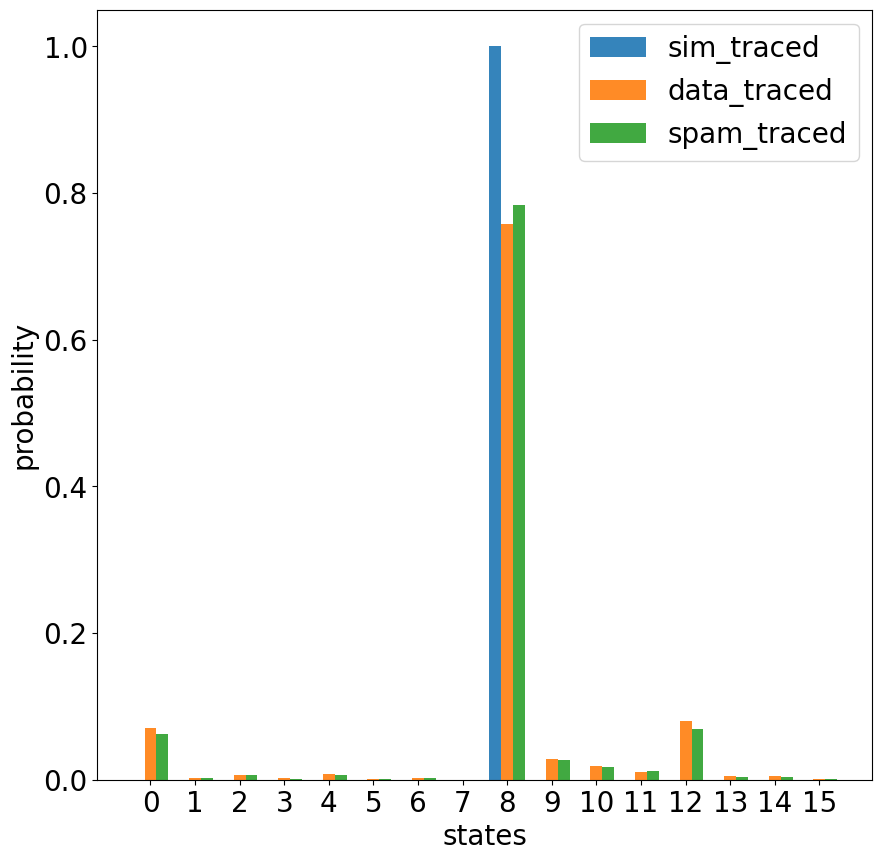

2023-05-16-195213_Line_002.txt
counts: [7, 25, 6, 3, 20, 433, 10, 39, 38, 146, 10, 5, 112, 2934, 36, 176]
counts_ibm_mapping_dic: {'0000': 7, '1000': 25, '0100': 6, '1100': 3, '0010': 20, '1010': 433, '0110': 10, '1110': 39, '0001': 38, '1001': 146, '0101': 10, '1101': 5, '0011': 112, '1011': 2934, '0111': 36, '1111': 176}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:RY+31:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



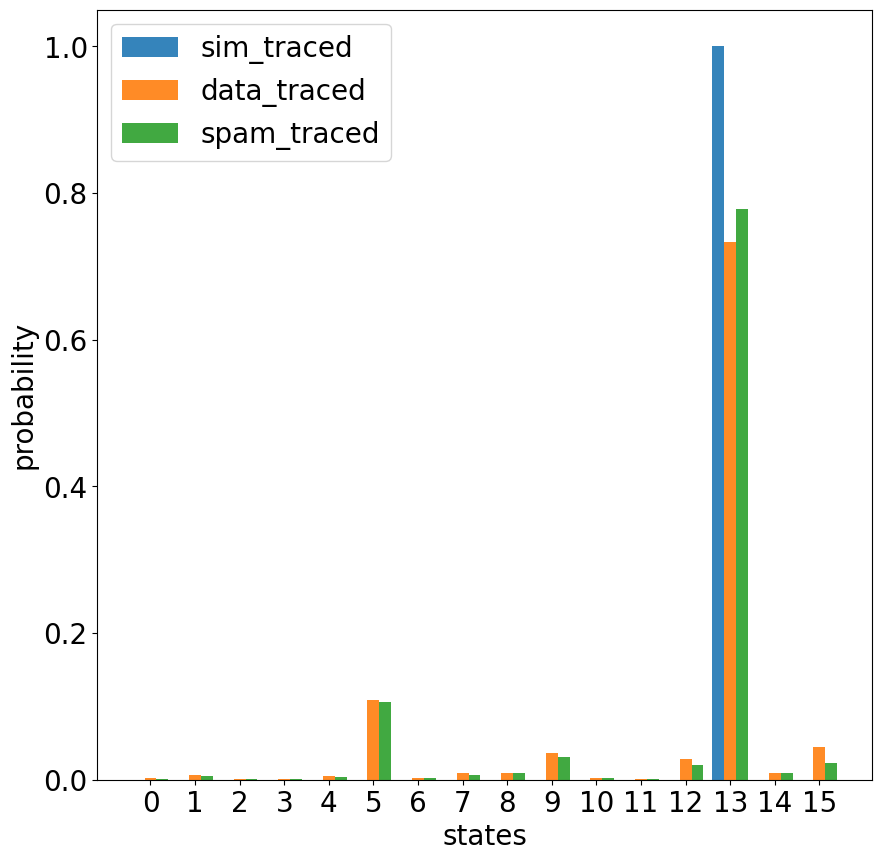

2023-05-16-195256_Line_003.txt
counts: [17, 395, 23, 20, 2, 48, 19, 0, 95, 3096, 18, 89, 13, 126, 31, 8]
counts_ibm_mapping_dic: {'0000': 17, '1000': 395, '0100': 23, '1100': 20, '0010': 2, '1010': 48, '0110': 19, '1110': 0, '0001': 95, '1001': 3096, '0101': 18, '1101': 89, '0011': 13, '1011': 126, '0111': 31, '1111': 8}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



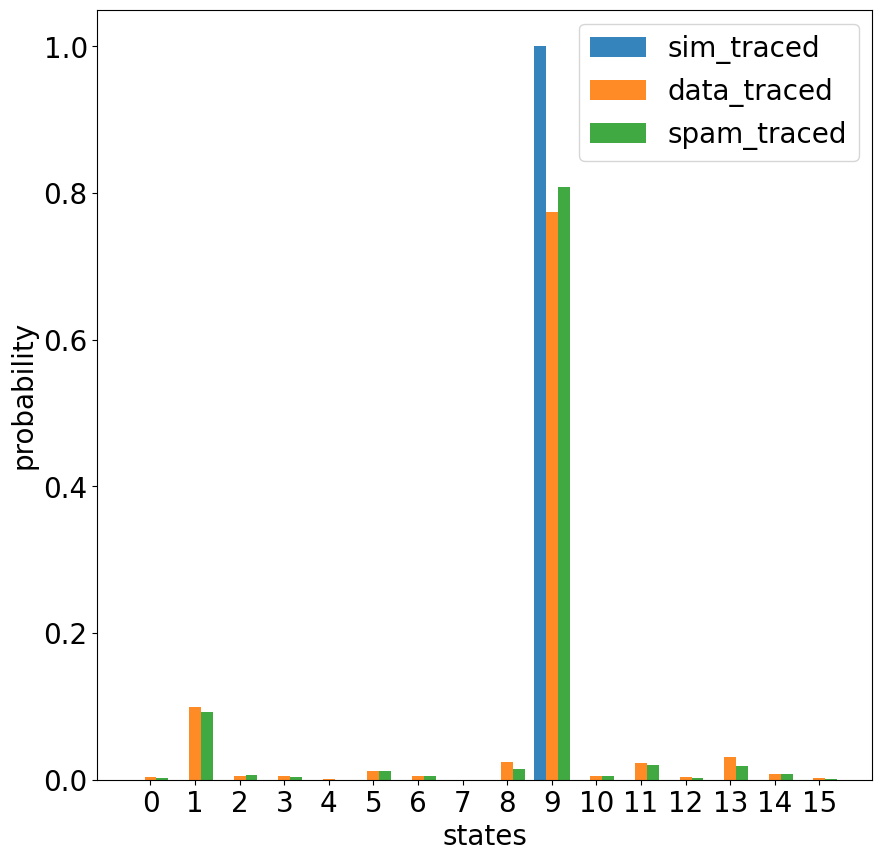

2023-05-16-195337_Line_004.txt
counts: [407, 5, 32, 23, 48, 2, 0, 4, 3005, 56, 92, 7, 279, 13, 23, 4]
counts_ibm_mapping_dic: {'0000': 407, '1000': 5, '0100': 32, '1100': 23, '0010': 48, '1010': 2, '0110': 0, '1110': 4, '0001': 3005, '1001': 56, '0101': 92, '1101': 7, '0011': 279, '1011': 13, '0111': 23, '1111': 4}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:AZ3+1.0000:FTXA130.2500+:RY+31:FTXA130.2500+:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



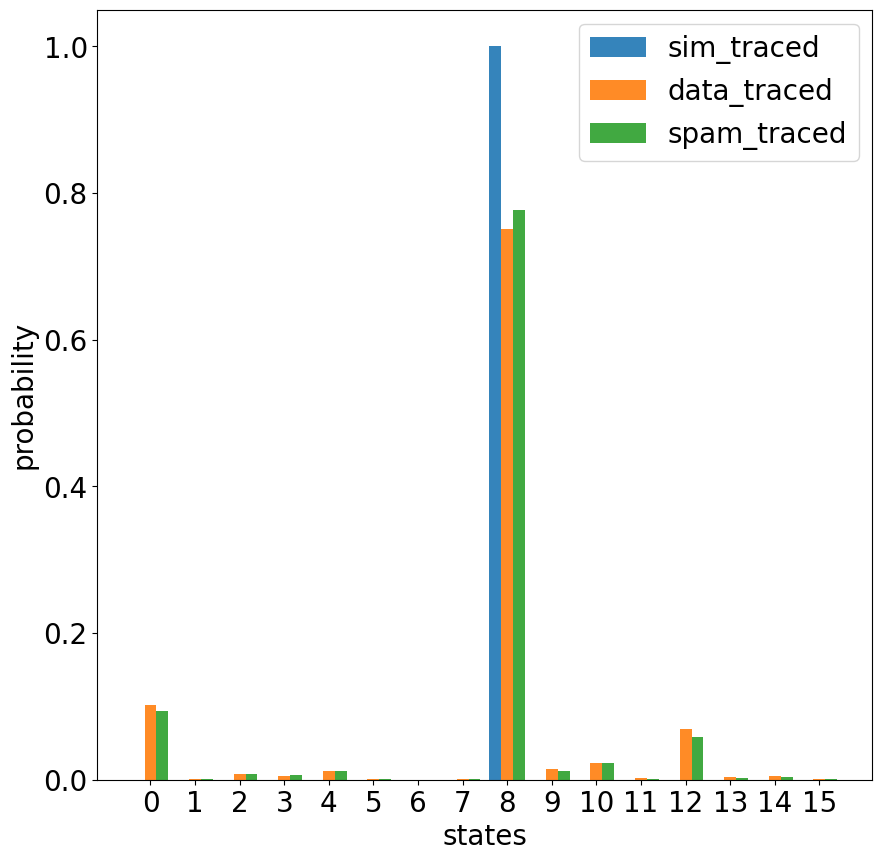

2023-05-16-195537_Line_005.txt
counts: [43, 13, 438, 26, 165, 18, 2720, 106, 16, 3, 62, 7, 32, 18, 319, 14]
counts_ibm_mapping_dic: {'0000': 43, '1000': 13, '0100': 438, '1100': 26, '0010': 165, '1010': 18, '0110': 2720, '1110': 106, '0001': 16, '1001': 3, '0101': 62, '1101': 7, '0011': 32, '1011': 18, '0111': 319, '1111': 14}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+11:RX+31:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:RX+11:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



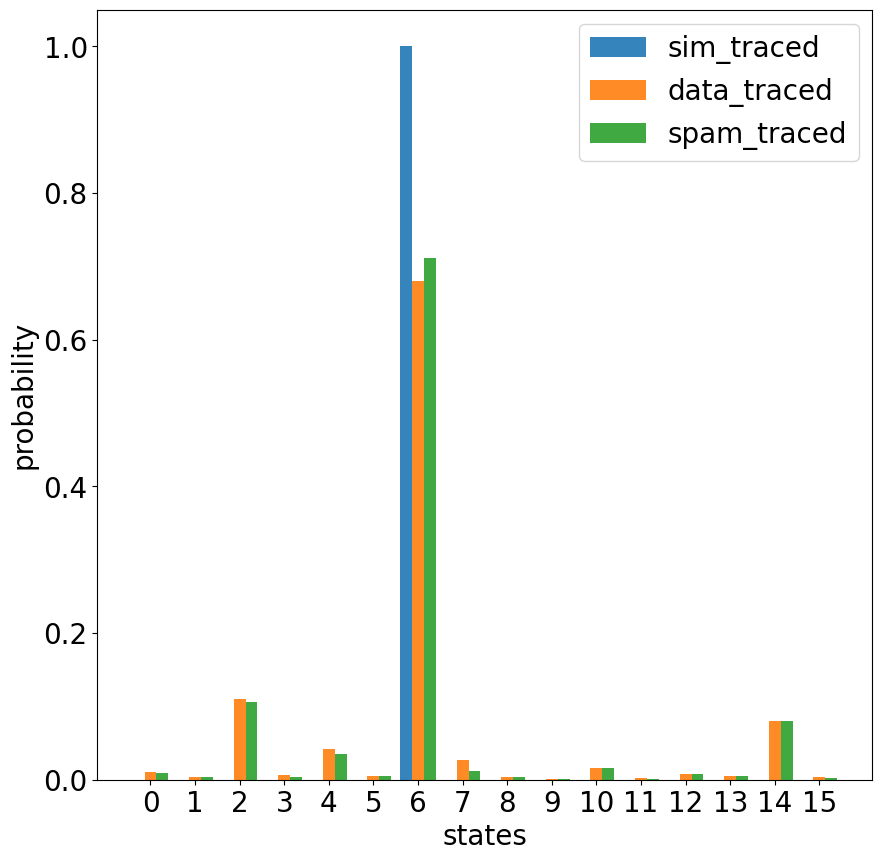

2023-05-16-195621_Line_006.txt
counts: [4, 2, 3, 30, 26, 41, 25, 574, 6, 11, 17, 136, 16, 162, 76, 2871]
counts_ibm_mapping_dic: {'0000': 4, '1000': 2, '0100': 3, '1100': 30, '0010': 26, '1010': 41, '0110': 25, '1110': 574, '0001': 6, '1001': 11, '0101': 17, '1101': 136, '0011': 16, '1011': 162, '0111': 76, '1111': 2871}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+31:FTXA130.2500+:RY+31:FTXA130.2500+:RY+11:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



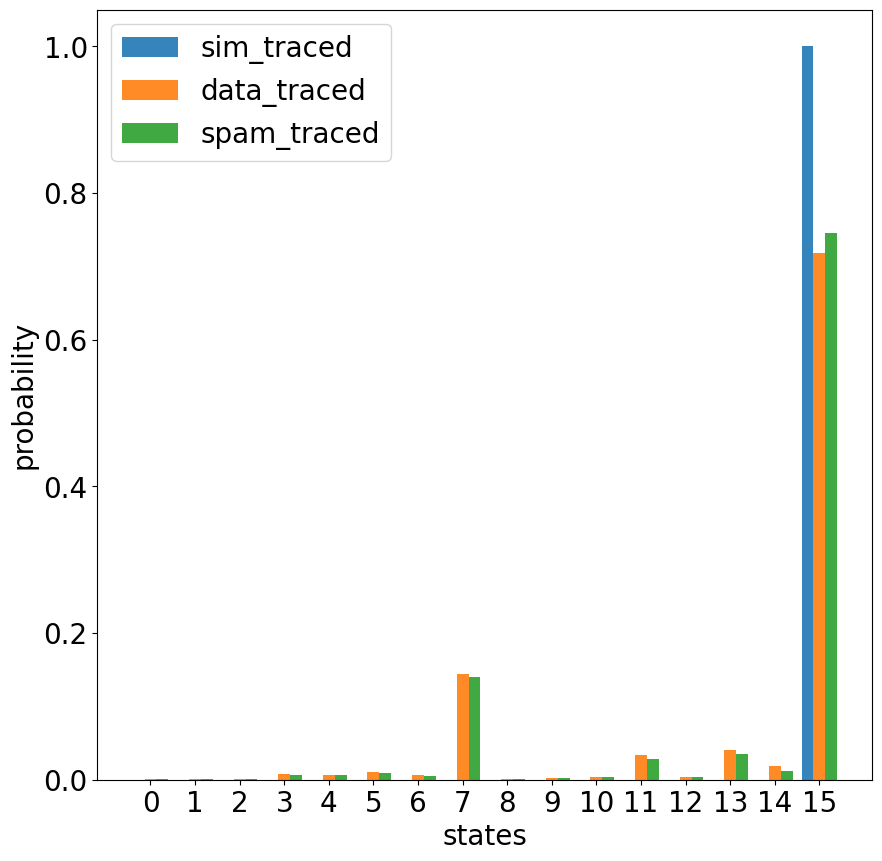

2023-05-16-195703_Line_007.txt
counts: [349, 17, 17, 7, 2915, 92, 136, 39, 44, 0, 2, 4, 291, 8, 40, 39]
counts_ibm_mapping_dic: {'0000': 349, '1000': 17, '0100': 17, '1100': 7, '0010': 2915, '1010': 92, '0110': 136, '1110': 39, '0001': 44, '1001': 0, '0101': 2, '1101': 4, '0011': 291, '1011': 8, '0111': 40, '1111': 39}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:RY+31:FTXA130.2500+:AZ1+1.0000:RY+31:FTXA130.2500+:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



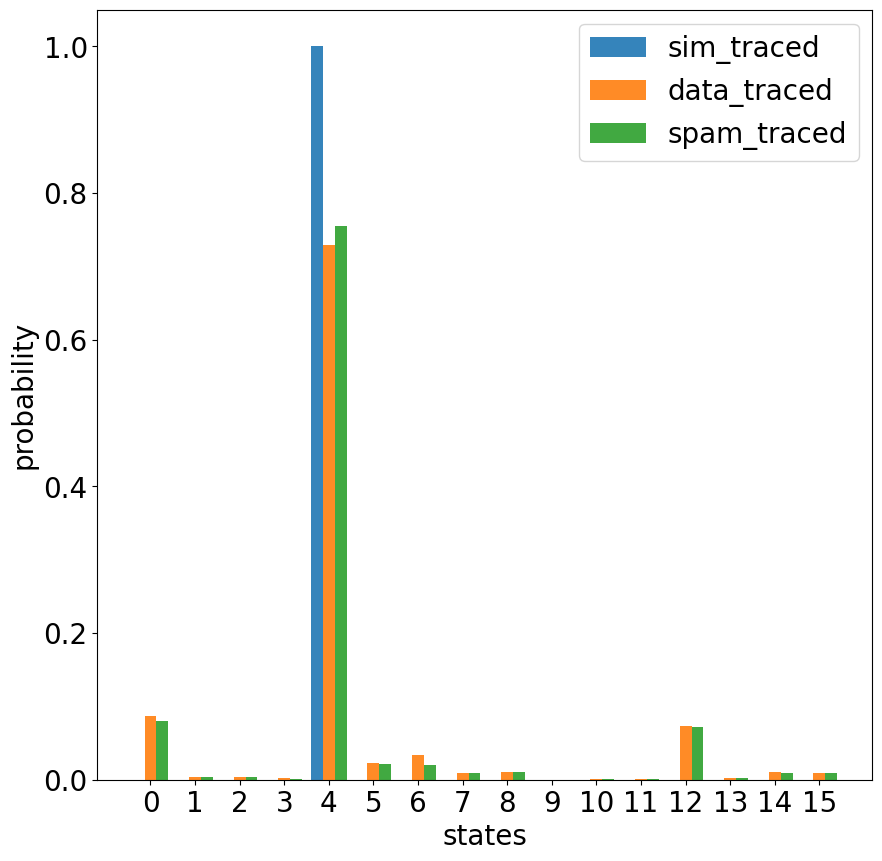

2023-05-16-195744_Line_008.txt
counts: [448, 31, 15, 5, 2826, 71, 89, 9, 71, 3, 1, 3, 341, 12, 45, 30]
counts_ibm_mapping_dic: {'0000': 448, '1000': 31, '0100': 15, '1100': 5, '0010': 2826, '1010': 71, '0110': 89, '1110': 9, '0001': 71, '1001': 3, '0101': 1, '1101': 3, '0011': 341, '1011': 12, '0111': 45, '1111': 30}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:AZ1+1.0000:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



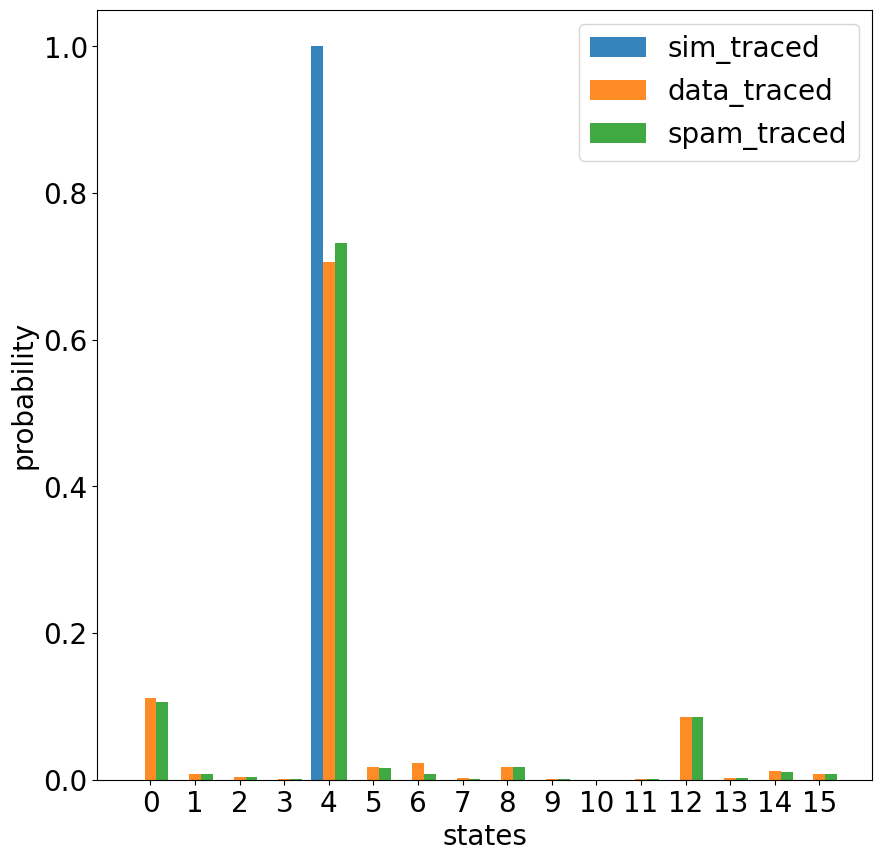

2023-05-16-195943_Line_009.txt
counts: [4, 9, 45, 2, 27, 23, 272, 23, 37, 26, 364, 27, 106, 16, 2852, 167]
counts_ibm_mapping_dic: {'0000': 4, '1000': 9, '0100': 45, '1100': 2, '0010': 27, '1010': 23, '0110': 272, '1110': 23, '0001': 37, '1001': 26, '0101': 364, '1101': 27, '0011': 106, '1011': 16, '0111': 2852, '1111': 167}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+11:RY+31:FTXA130.2500+:AZ1+1.0000:FTXA130.2500+:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



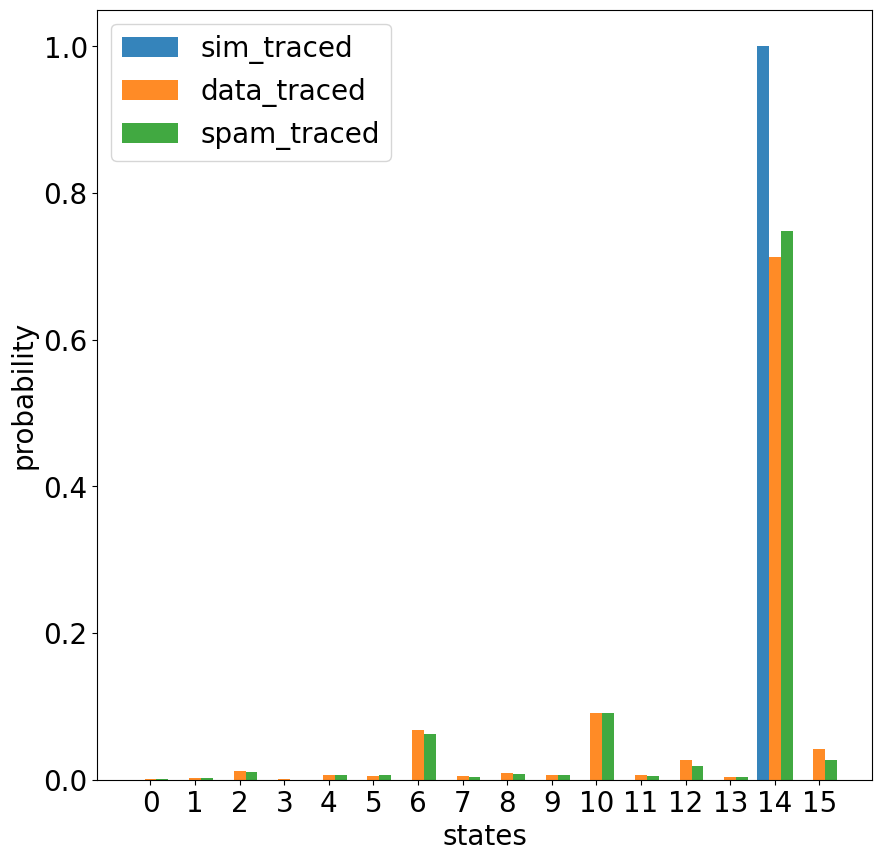

2023-05-16-200028_Line_010.txt
counts: [6, 17, 28, 166, 14, 131, 99, 3121, 1, 4, 4, 25, 26, 30, 15, 313]
counts_ibm_mapping_dic: {'0000': 6, '1000': 17, '0100': 28, '1100': 166, '0010': 14, '1010': 131, '0110': 99, '1110': 3121, '0001': 1, '1001': 4, '0101': 4, '1101': 25, '0011': 26, '1011': 30, '0111': 15, '1111': 313}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:RX+31:FTXA130.2500+:RY+31:FTXA130.2500+:AZ1+1.0000:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



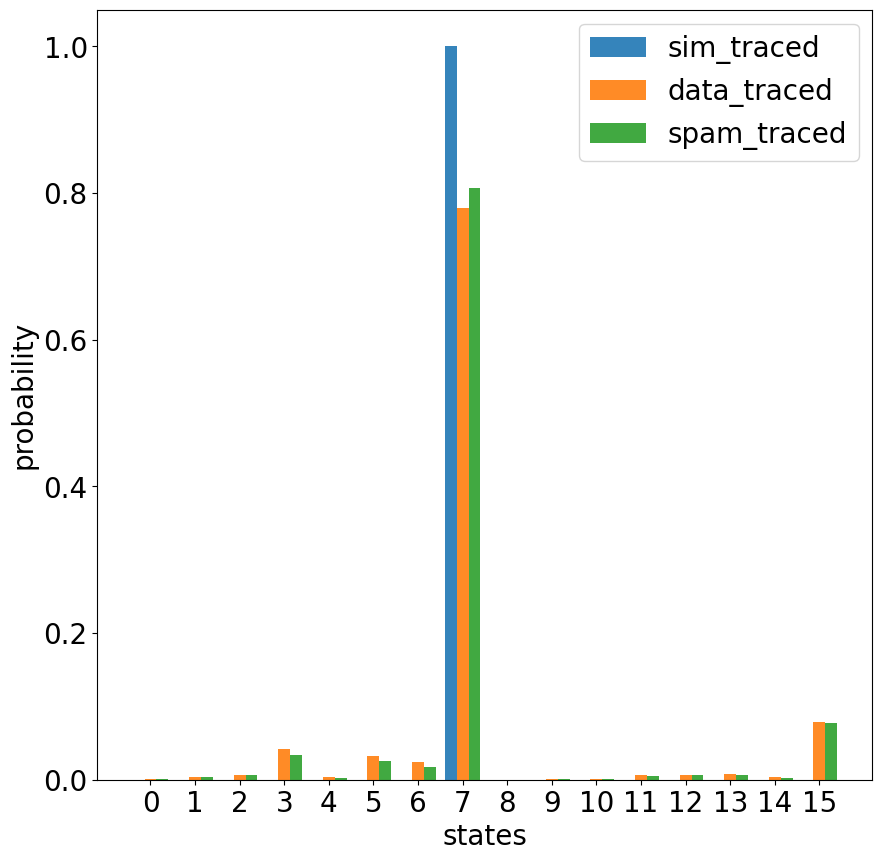

2023-05-16-200111_Line_011.txt
counts: [7, 38, 7, 7, 15, 402, 32, 33, 10, 140, 9, 5, 116, 2995, 23, 161]
counts_ibm_mapping_dic: {'0000': 7, '1000': 38, '0100': 7, '1100': 7, '0010': 15, '1010': 402, '0110': 32, '1110': 33, '0001': 10, '1001': 140, '0101': 9, '1101': 5, '0011': 116, '1011': 2995, '0111': 23, '1111': 161}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



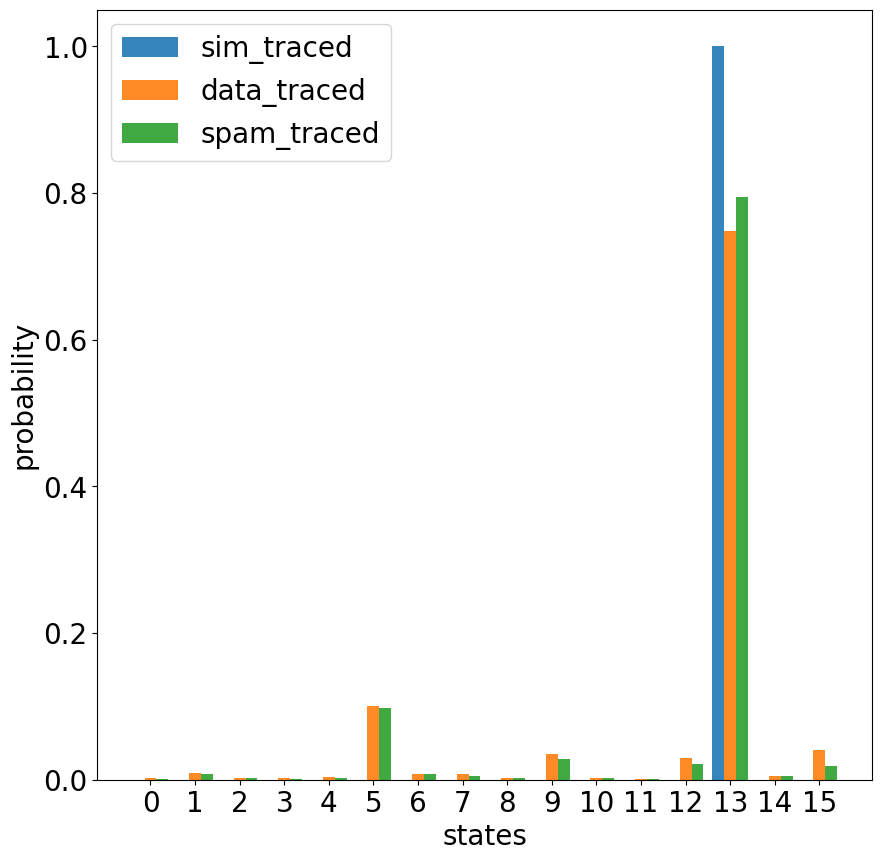

2023-05-16-200152_Line_012.txt
counts: [2929, 61, 92, 64, 379, 19, 25, 8, 304, 10, 26, 18, 53, 3, 6, 3]
counts_ibm_mapping_dic: {'0000': 2929, '1000': 61, '0100': 92, '1100': 64, '0010': 379, '1010': 19, '0110': 25, '1110': 8, '0001': 304, '1001': 10, '0101': 26, '1101': 18, '0011': 53, '1011': 3, '0111': 6, '1111': 3}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:FTXA130.2500+:RX+31:FTXA130.2500+:RX+11:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



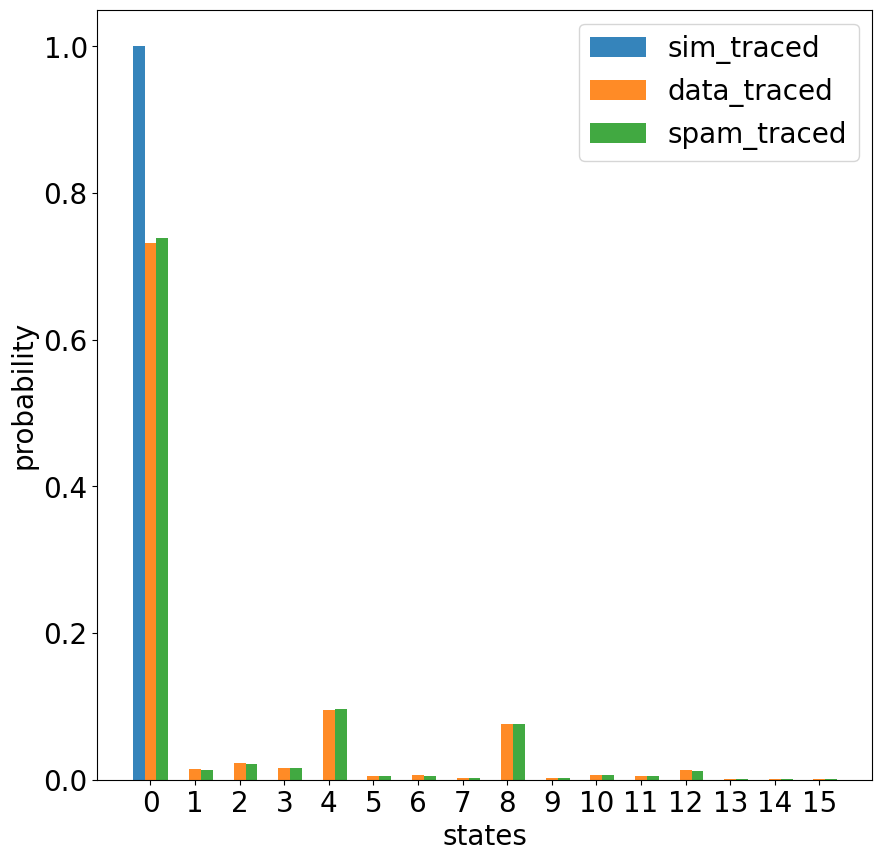

2023-05-16-200351_Line_013.txt
counts: [27, 34, 498, 20, 10, 6, 62, 5, 106, 35, 2600, 124, 31, 28, 381, 33]
counts_ibm_mapping_dic: {'0000': 27, '1000': 34, '0100': 498, '1100': 20, '0010': 10, '1010': 6, '0110': 62, '1110': 5, '0001': 106, '1001': 35, '0101': 2600, '1101': 124, '0011': 31, '1011': 28, '0111': 381, '1111': 33}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+31:FTXA130.2500+:FTXA130.2500+:AZ1+1.0000:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



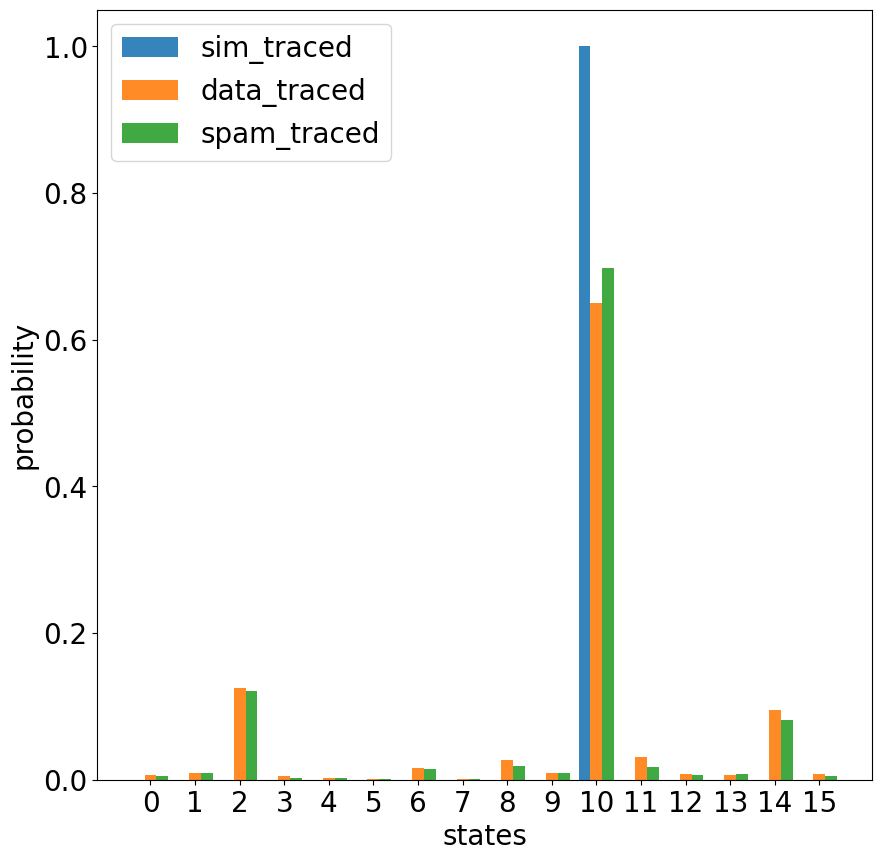

2023-05-16-200434_Line_014.txt
counts: [281, 16, 26, 7, 53, 5, 6, 0, 3011, 68, 77, 16, 389, 14, 22, 9]
counts_ibm_mapping_dic: {'0000': 281, '1000': 16, '0100': 26, '1100': 7, '0010': 53, '1010': 5, '0110': 6, '1110': 0, '0001': 3011, '1001': 68, '0101': 77, '1101': 16, '0011': 389, '1011': 14, '0111': 22, '1111': 9}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+11:FTXA130.2500+:RY+11:RY+31:FTXA130.2500+:RX+11:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



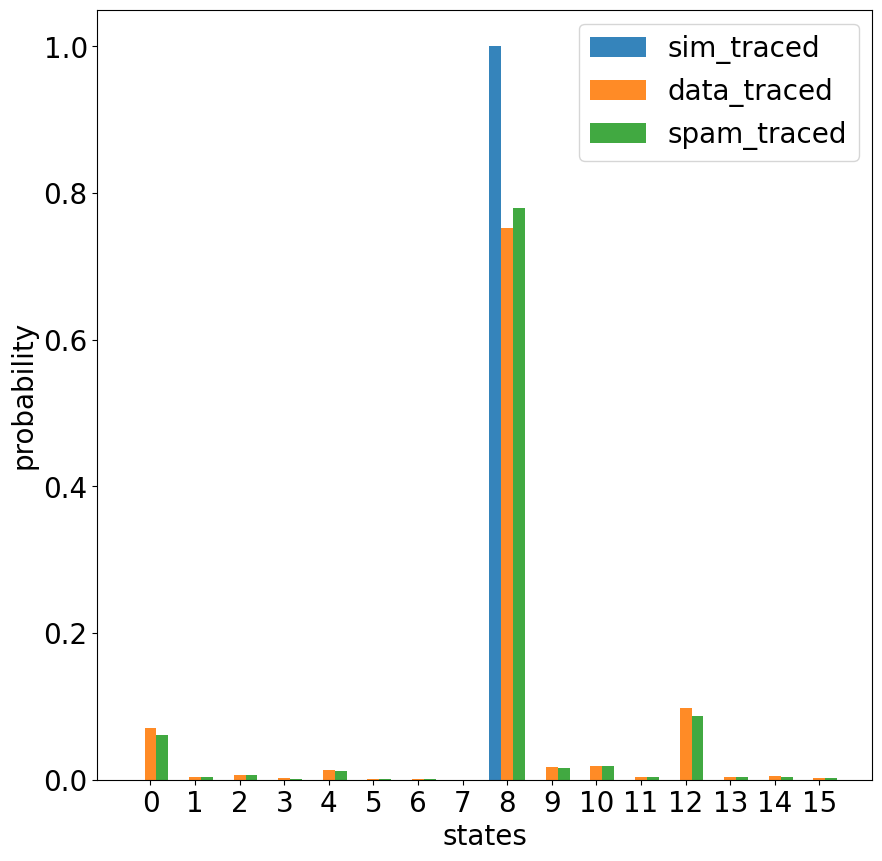

2023-05-16-200516_Line_015.txt
counts: [9, 62, 15, 371, 2, 4, 6, 36, 12, 101, 109, 3049, 28, 18, 19, 159]
counts_ibm_mapping_dic: {'0000': 9, '1000': 62, '0100': 15, '1100': 371, '0010': 2, '1010': 4, '0110': 6, '1110': 36, '0001': 12, '1001': 101, '0101': 109, '1101': 3049, '0011': 28, '1011': 18, '0111': 19, '1111': 159}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:RX+11:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



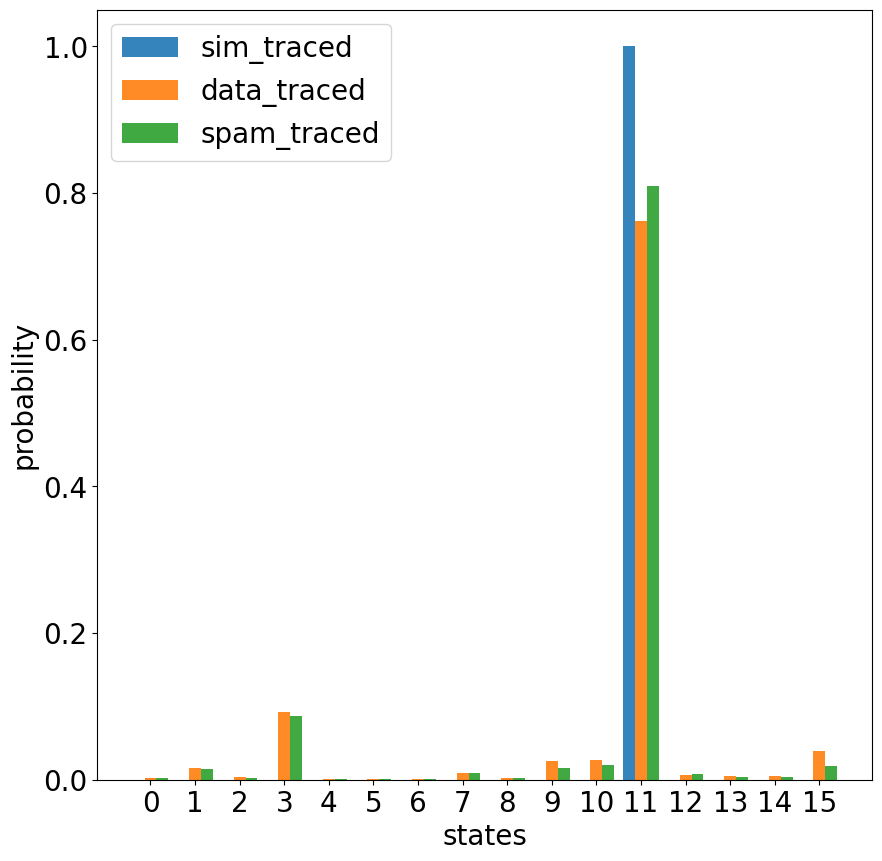

2023-05-16-200559_Line_016.txt
counts: [102, 39, 2772, 105, 23, 8, 338, 24, 26, 32, 437, 22, 7, 6, 53, 6]
counts_ibm_mapping_dic: {'0000': 102, '1000': 39, '0100': 2772, '1100': 105, '0010': 23, '1010': 8, '0110': 338, '1110': 24, '0001': 26, '1001': 32, '0101': 437, '1101': 22, '0011': 7, '1011': 6, '0111': 53, '1111': 6}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+31:FTXA130.2500+:RX+31:FTXA130.2500+:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



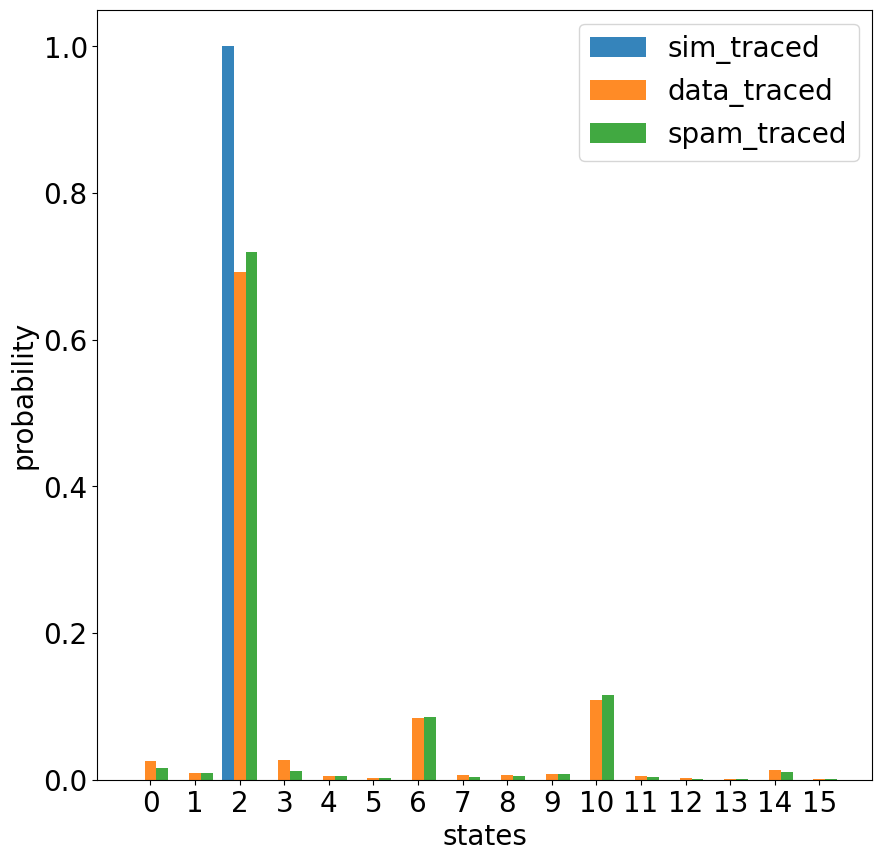

2023-05-16-200758_Line_017.txt
counts: [38, 3, 4, 1, 282, 10, 27, 20, 495, 24, 14, 4, 2876, 67, 118, 17]
counts_ibm_mapping_dic: {'0000': 38, '1000': 3, '0100': 4, '1100': 1, '0010': 282, '1010': 10, '0110': 27, '1110': 20, '0001': 495, '1001': 24, '0101': 14, '1101': 4, '0011': 2876, '1011': 67, '0111': 118, '1111': 17}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:RX+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RY+11:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



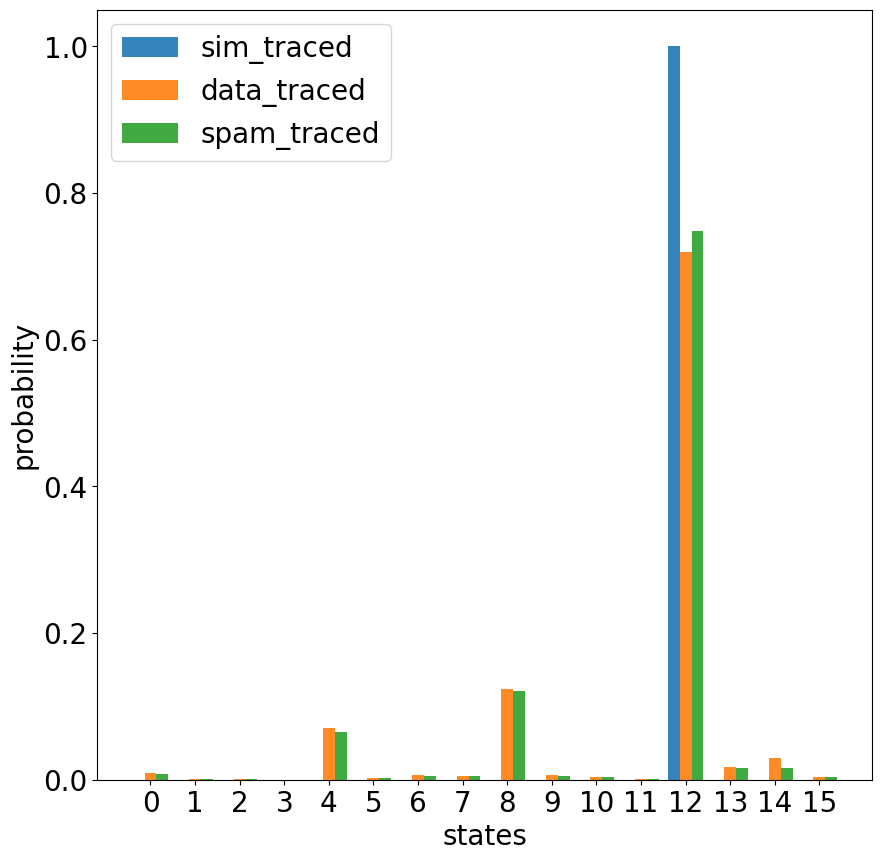

2023-05-16-200840_Line_018.txt
counts: [32, 8, 24, 160, 9, 110, 96, 3001, 9, 4, 1, 48, 5, 31, 15, 447]
counts_ibm_mapping_dic: {'0000': 32, '1000': 8, '0100': 24, '1100': 160, '0010': 9, '1010': 110, '0110': 96, '1110': 3001, '0001': 9, '1001': 4, '0101': 1, '1101': 48, '0011': 5, '1011': 31, '0111': 15, '1111': 447}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:AZ3+1.0000:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



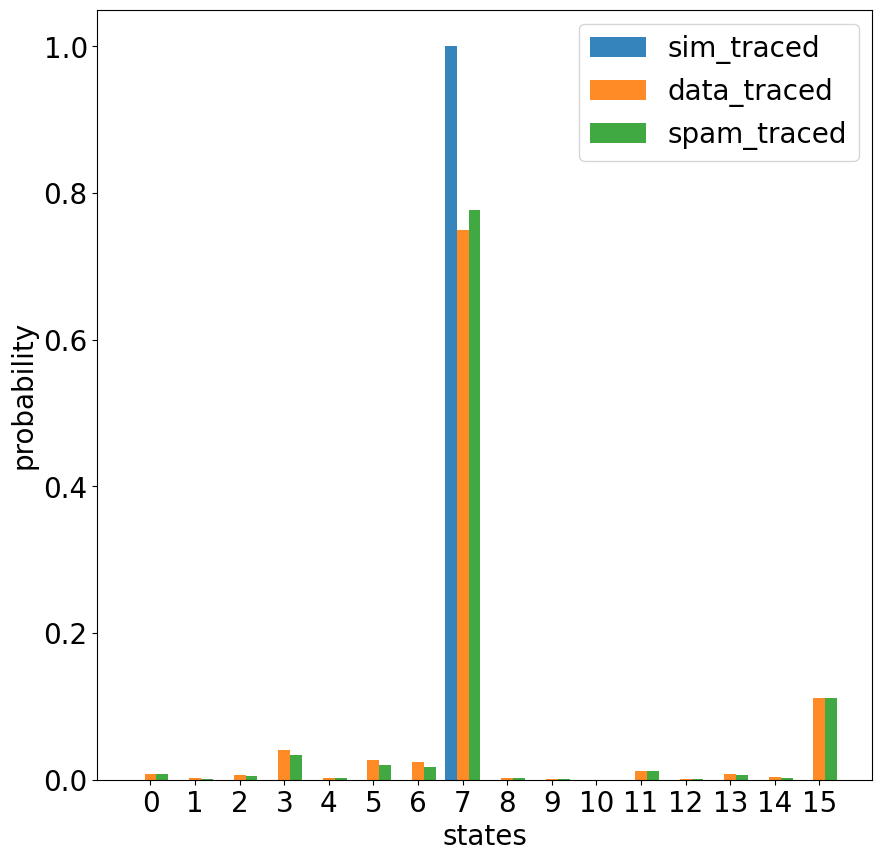

2023-05-16-200923_Line_019.txt
counts: [61, 3, 4, 5, 381, 19, 25, 29, 279, 20, 8, 7, 2945, 85, 114, 15]
counts_ibm_mapping_dic: {'0000': 61, '1000': 3, '0100': 4, '1100': 5, '0010': 381, '1010': 19, '0110': 25, '1110': 29, '0001': 279, '1001': 20, '0101': 8, '1101': 7, '0011': 2945, '1011': 85, '0111': 114, '1111': 15}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:AZ1+1.0000:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



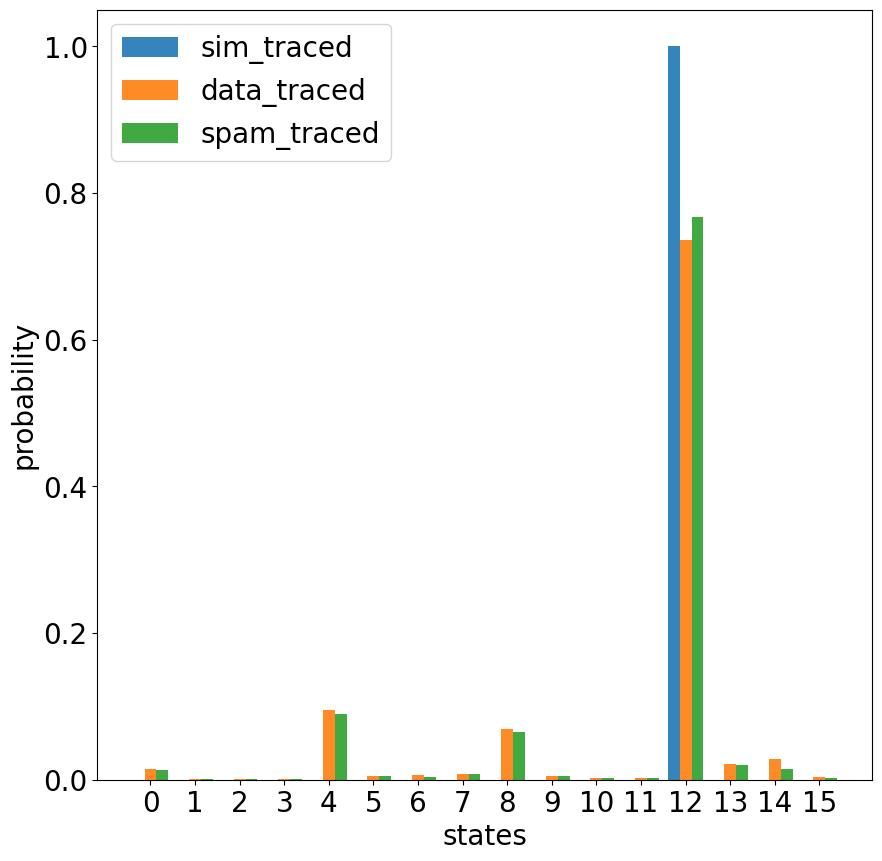

2023-05-16-201005_Line_020.txt
counts: [77, 4, 8, 2, 308, 7, 25, 11, 446, 19, 33, 7, 2811, 65, 167, 10]
counts_ibm_mapping_dic: {'0000': 77, '1000': 4, '0100': 8, '1100': 2, '0010': 308, '1010': 7, '0110': 25, '1110': 11, '0001': 446, '1001': 19, '0101': 33, '1101': 7, '0011': 2811, '1011': 65, '0111': 167, '1111': 10}
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+11:RY+31:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:AZ1+1.0000:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



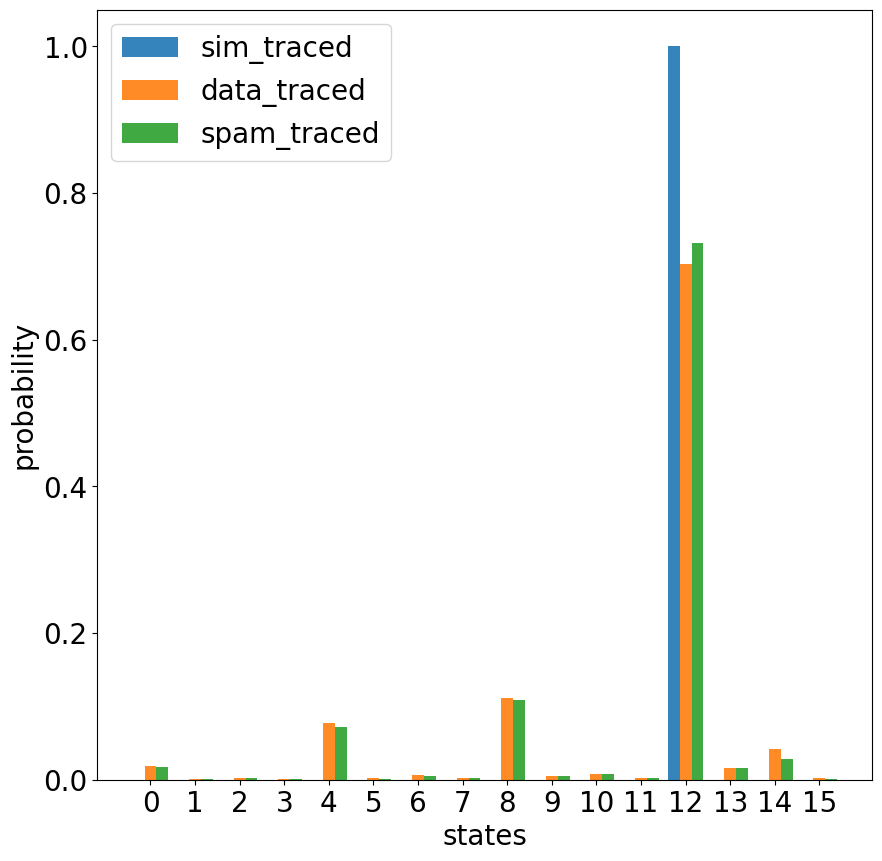

In [15]:
filenames_data=[]
counts_d2=[]
counts_d2_spam=[]
shots=4000
counts=[]
counts_spam=[]
filenames_data=filenames_d2.copy()
# print (filenames_data)
# print (len(filenames_data))
paf_data=paf_data_d2
circuit=c_d2
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    print ("counts:", counts)
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
    counts_d2.append(counts_ibm_mapping_dic)
    
    a_s=spam1.Correct_SPAM(a)
    data_traced_spam=Trace_Out(a_s,[0,1,2,3])
    counts_spam=[round(shots*x) for x in  data_traced_spam.population]
    counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
    counts_d2_spam.append(counts_ibm_mapping_dic_spam)

    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=2","spam"])
    Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])
# #         

['2023-05-16-201540_Line_001.txt', '2023-05-16-201631_Line_002.txt', '2023-05-16-205640_Line_003.txt', '2023-05-16-205731_Line_004.txt', '2023-05-16-205822_Line_005.txt', '2023-05-16-210030_Line_006.txt', '2023-05-16-210122_Line_007.txt', '2023-05-16-210213_Line_008.txt', '2023-05-16-212300_Line_009.txt', '2023-05-16-212351_Line_010.txt', '2023-05-16-212443_Line_011.txt', '2023-05-16-212533_Line_012.txt', '2023-05-16-231203_Line_013.txt', '2023-05-16-231254_Line_014.txt', '2023-05-16-231344_Line_015.txt', '2023-05-16-231435_Line_016.txt', '2023-05-16-231643_Line_017.txt', '2023-05-16-231733_Line_018.txt', '2023-05-16-231823_Line_019.txt', '2023-05-16-231914_Line_020.txt']
2023-05-16-201540_Line_001.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+31:FTXA130.2500+:RX+11:FTXA130.2500+:RY+11:RY+31:FTXA130.2500+:FTXA130.2500+:RX+11:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



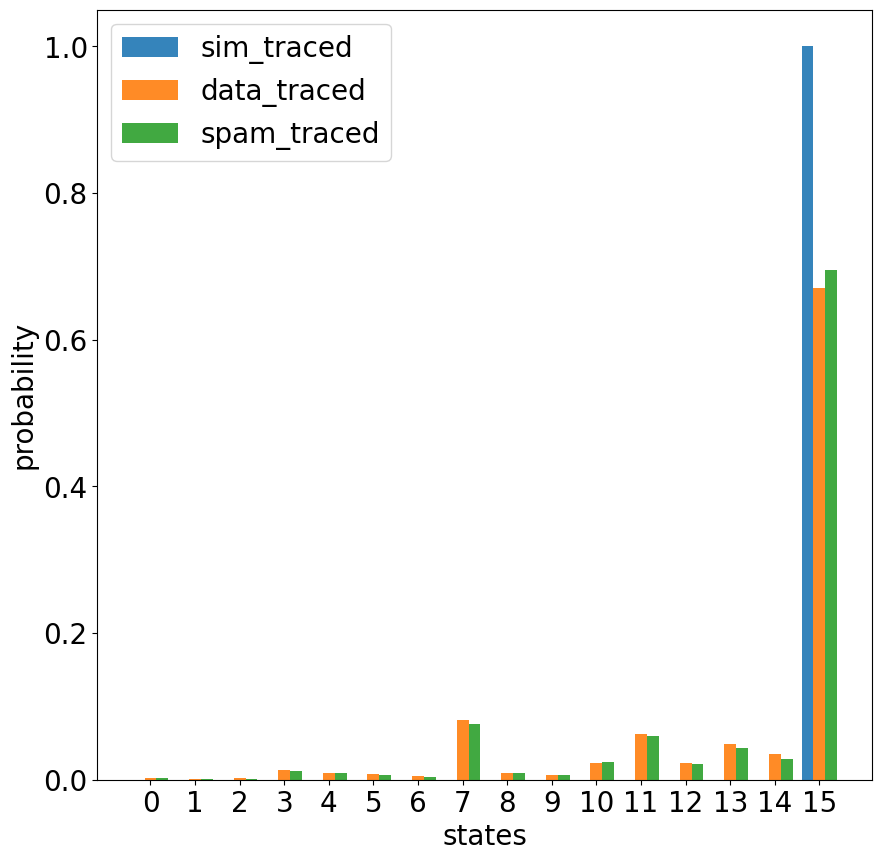

2023-05-16-201631_Line_002.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:FTXA130.2500+:RY+11:RY+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:FTXA130.2500+:AZ1+1.0000:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



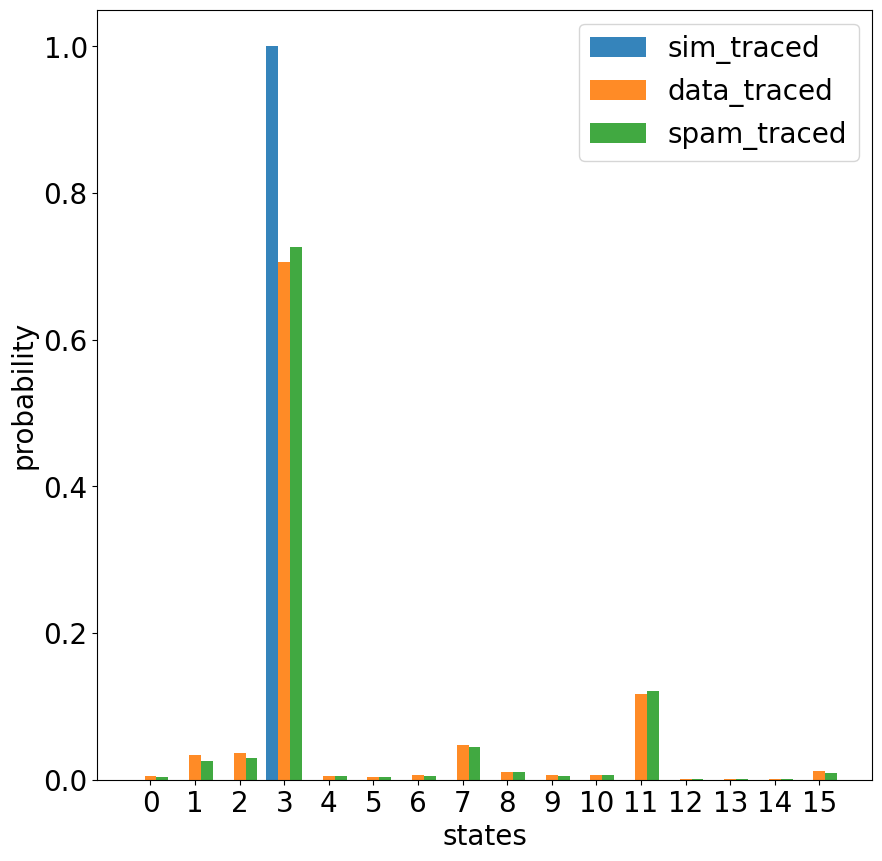

2023-05-16-205640_Line_003.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+11:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:AZ1+1.0000:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



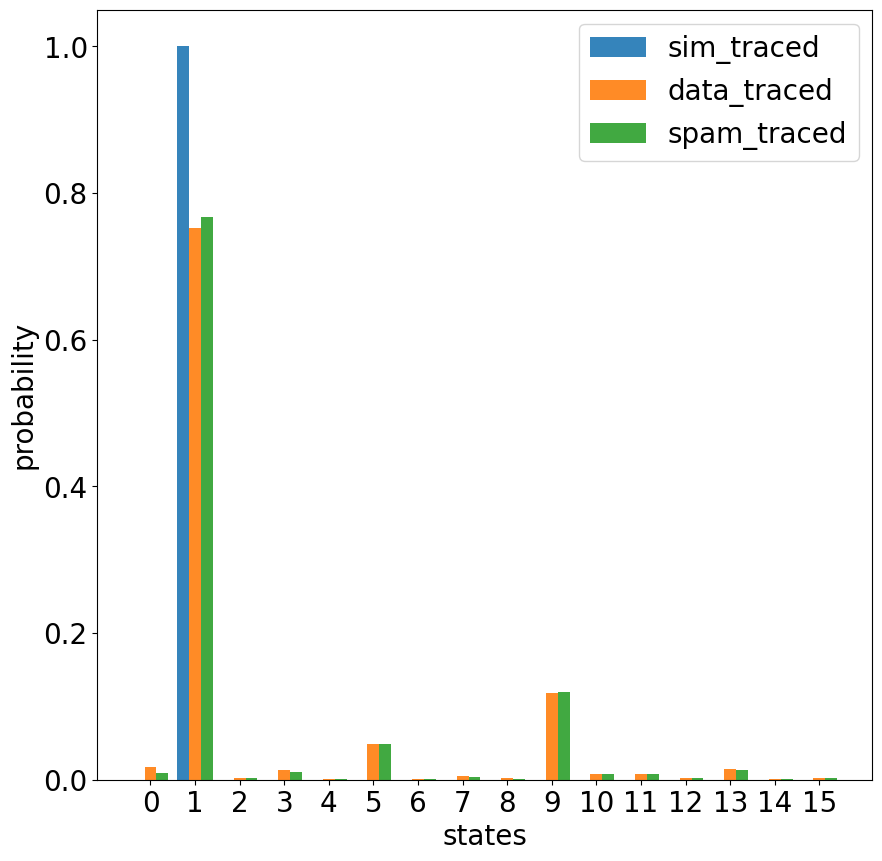

2023-05-16-205731_Line_004.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:RY+31:FTXA130.2500+:RX+31:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



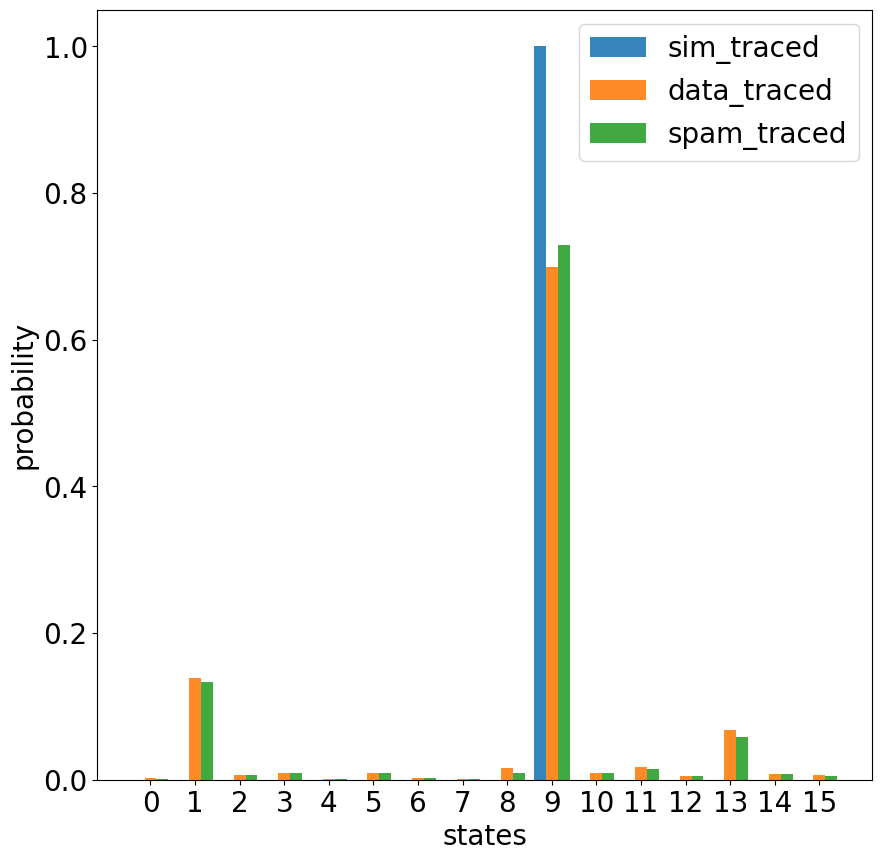

2023-05-16-205822_Line_005.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+31:FTXA130.2500+:RY+11:AZ3+1.0000:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RY+11:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



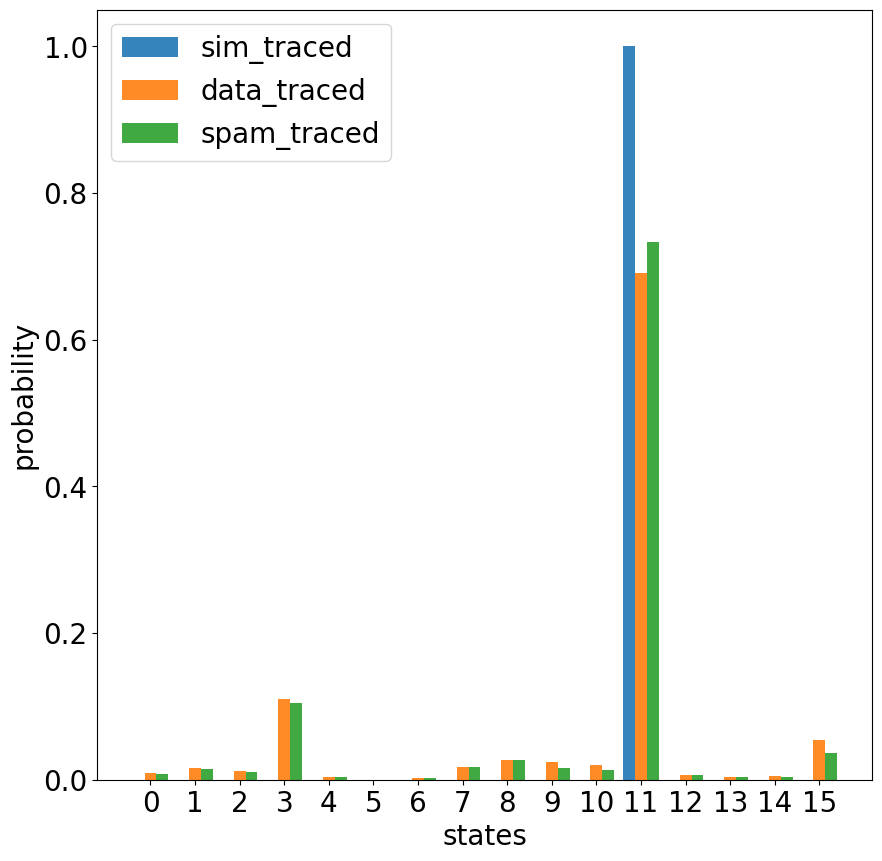

2023-05-16-210030_Line_006.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:RY+31:FTXA130.2500+:AZ1+1.0000:AZ3+1.0000:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



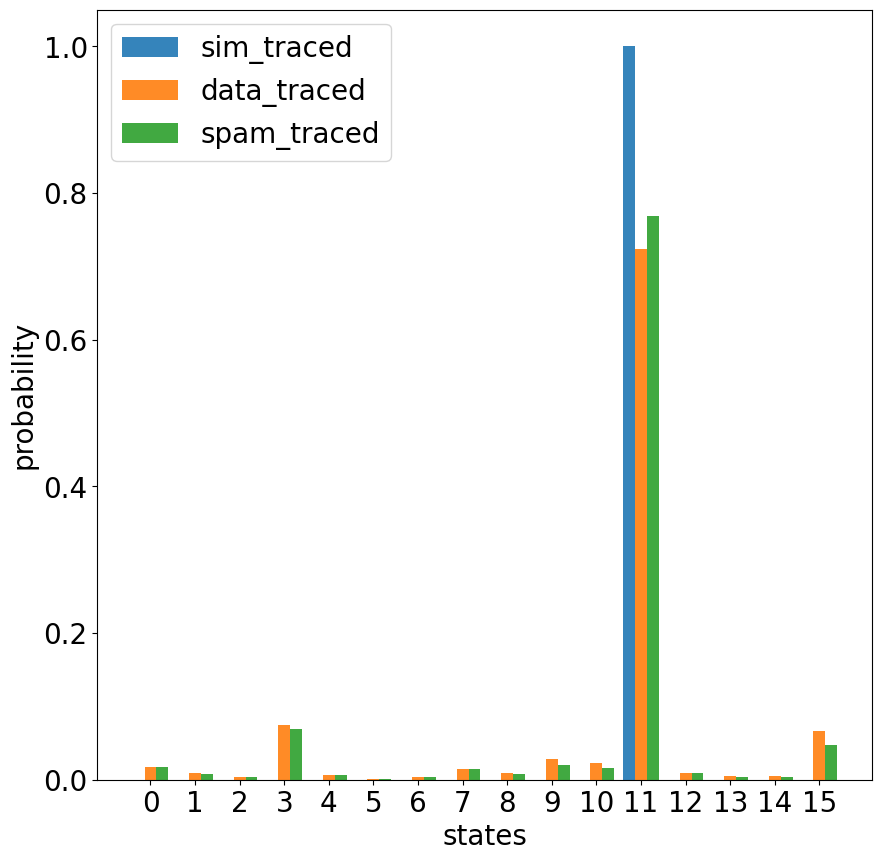

2023-05-16-210122_Line_007.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:RY+31:FTXA130.2500+:RX+11:FTXA130.2500+:RX+31:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



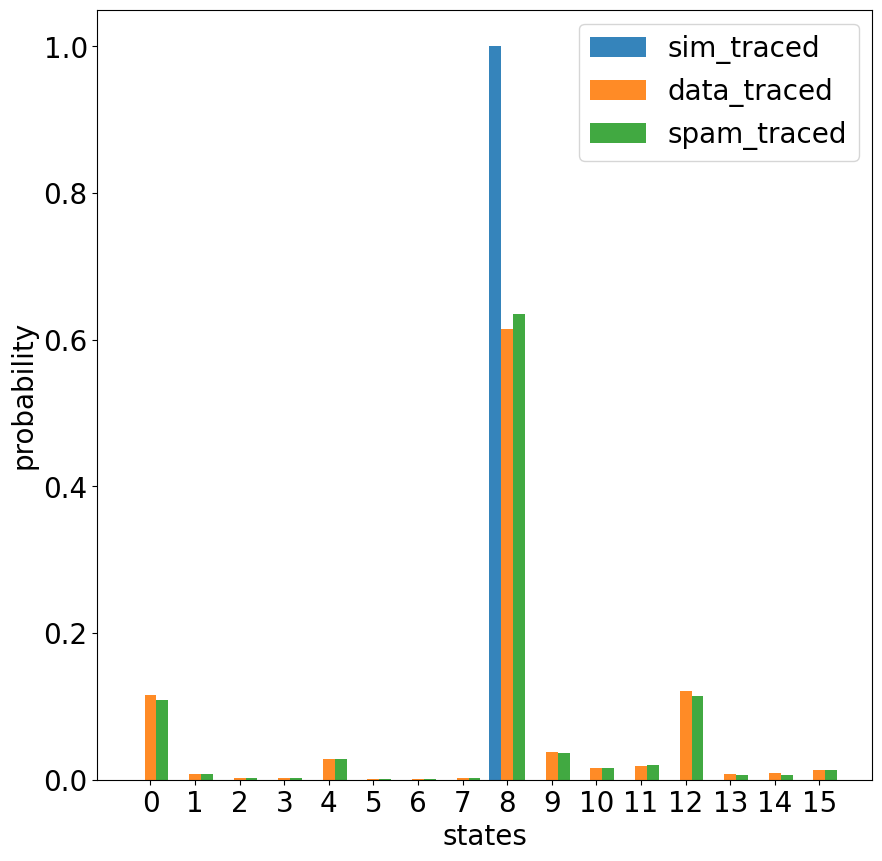

2023-05-16-210213_Line_008.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+11:RY+31:FTXA130.2500+:RY+11:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:FTXA130.2500+:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



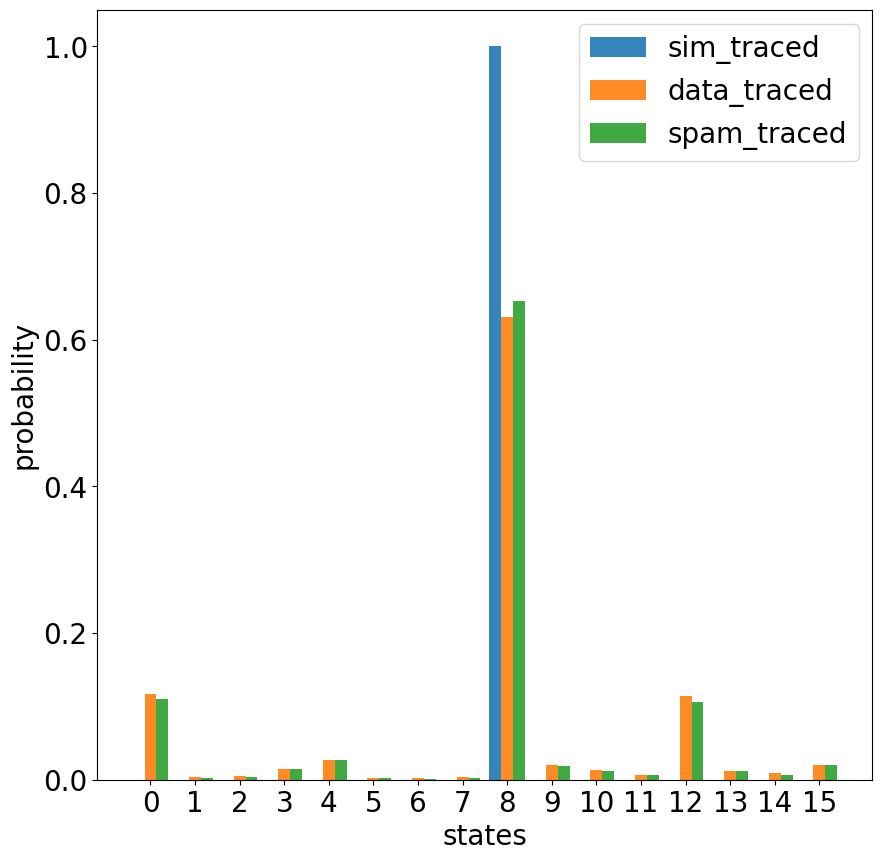

2023-05-16-212300_Line_009.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:RX+31:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:FTXA130.2500+:RX+11:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



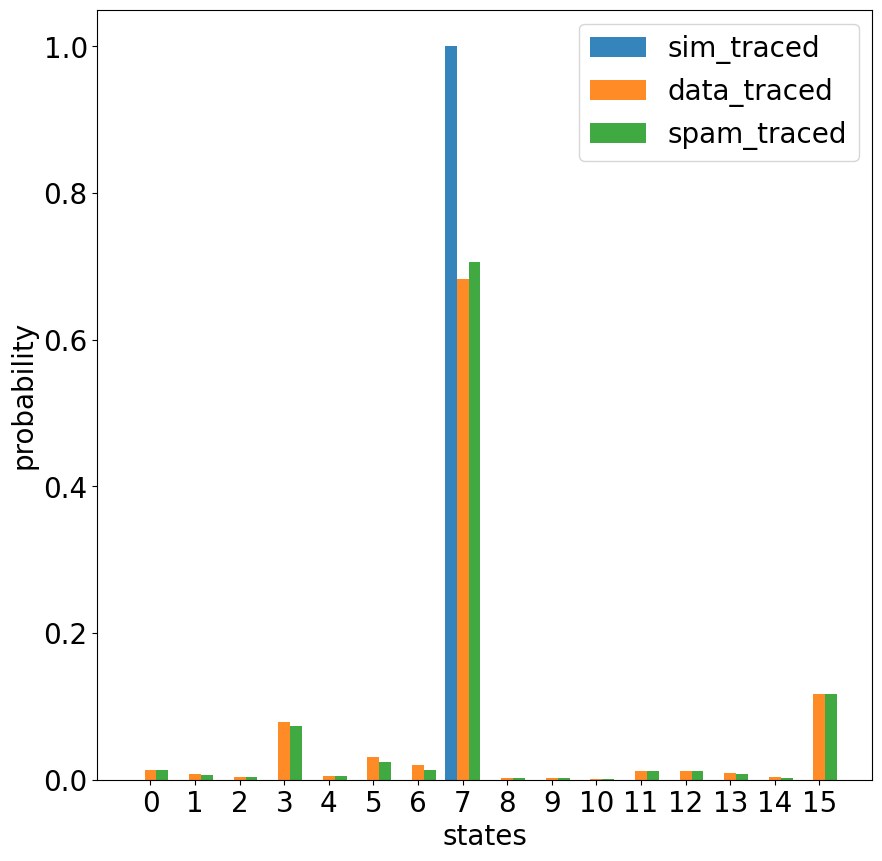

2023-05-16-212351_Line_010.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:RX+31:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:RY+11:RX+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RX+11:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



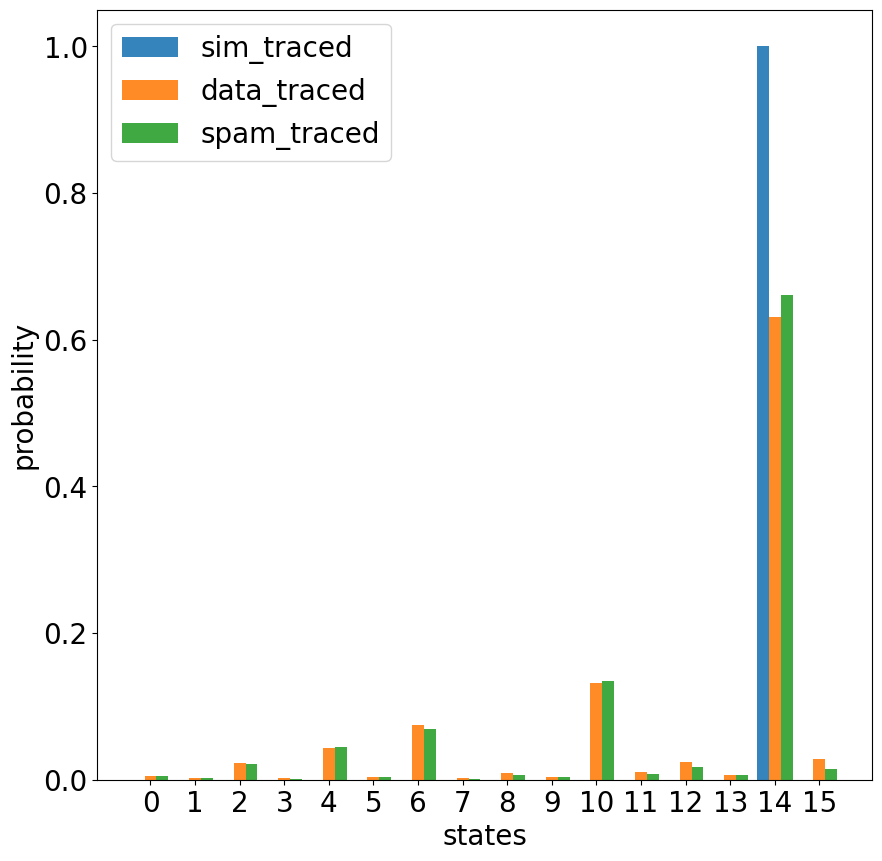

2023-05-16-212443_Line_011.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:FTXA130.2500+:RY+11:RY+31:FTXA130.2500+:RY+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RX+11:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



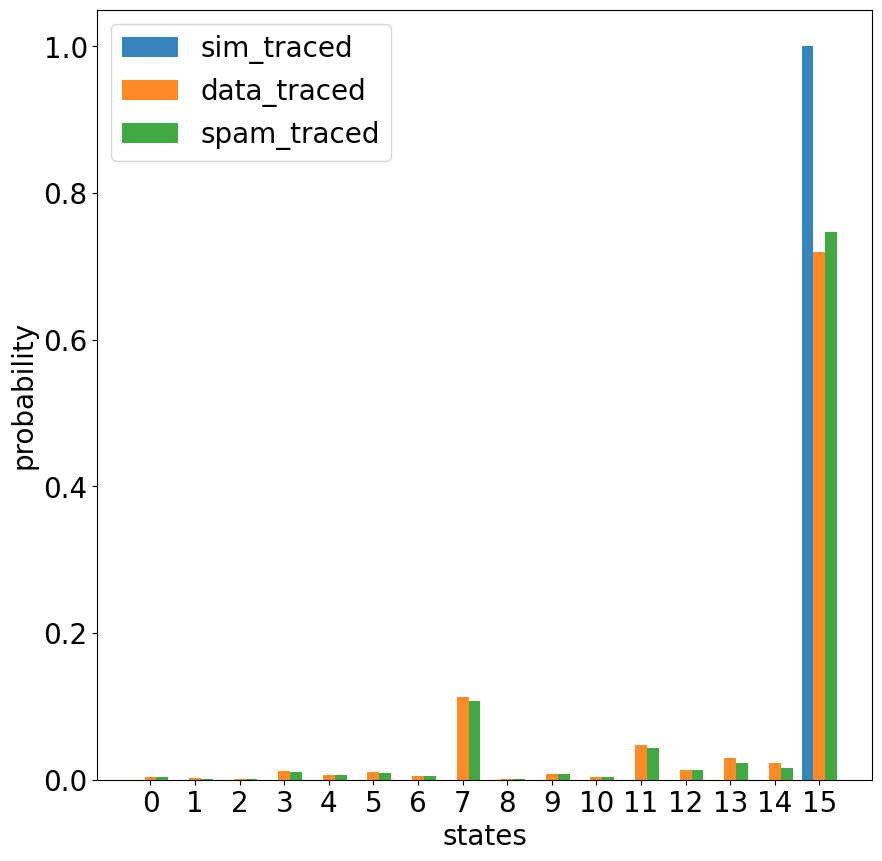

2023-05-16-212533_Line_012.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+31:FTXA130.2500+:AZ1+1.0000:RY+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RY+11:AZ3+1.0000:FTXA130.2500+:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



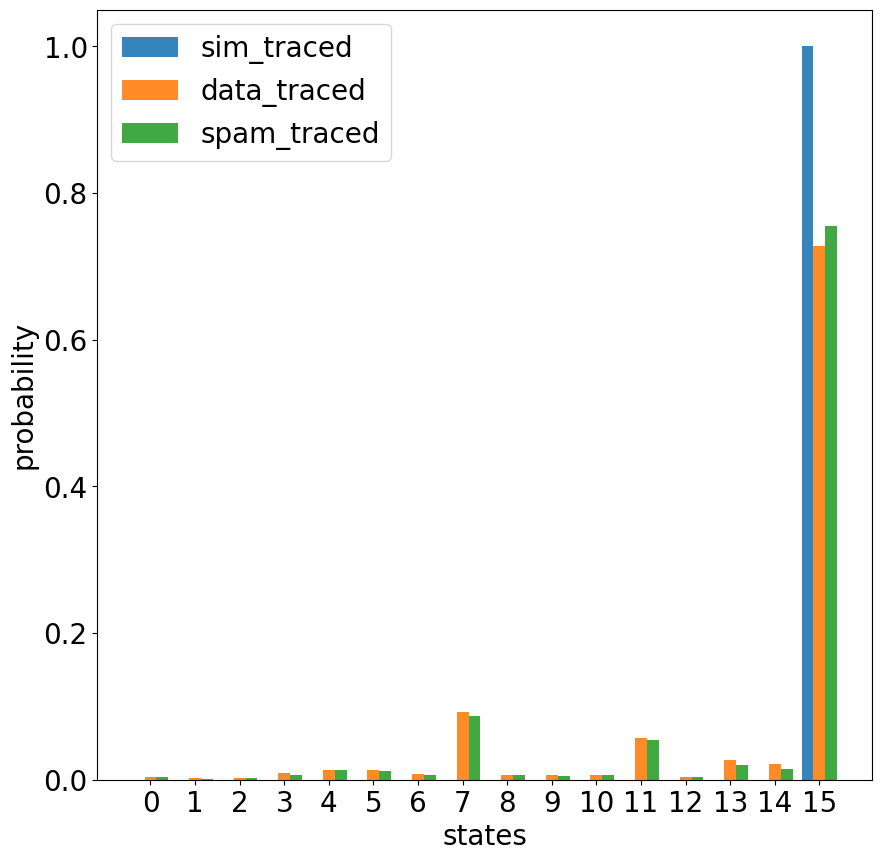

2023-05-16-231203_Line_013.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+11:RX+31:FTXA130.2500+:RX+11:FTXA130.2500+:RY+11:AZ3+1.0000:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



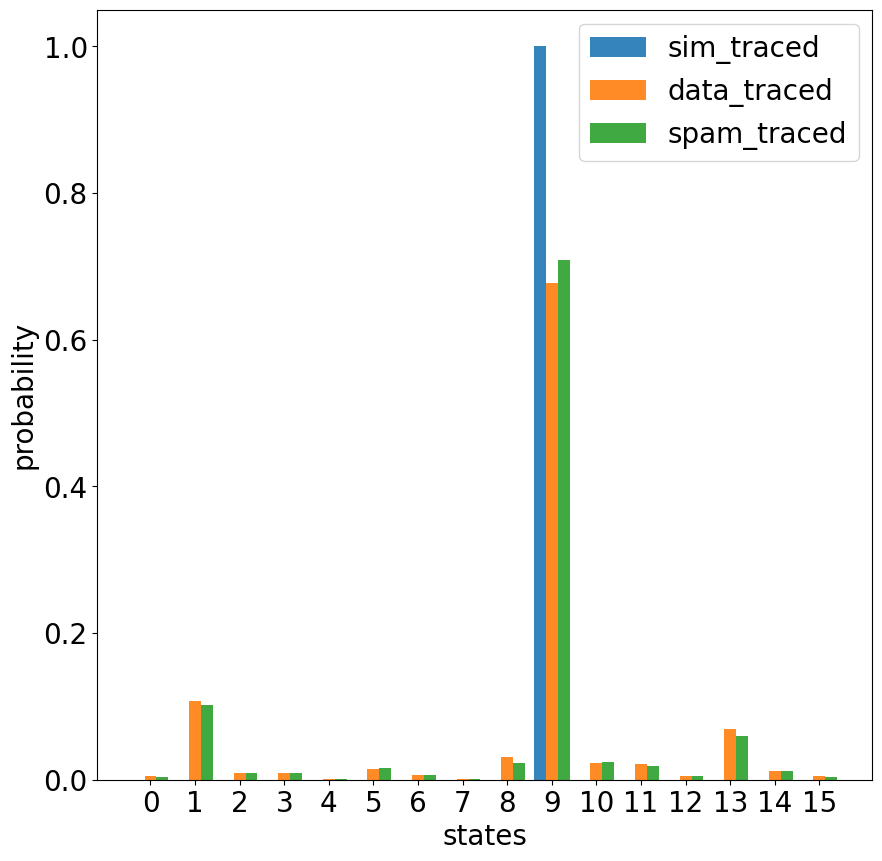

2023-05-16-231254_Line_014.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:RY+31:FTXA130.2500+:RY+31:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



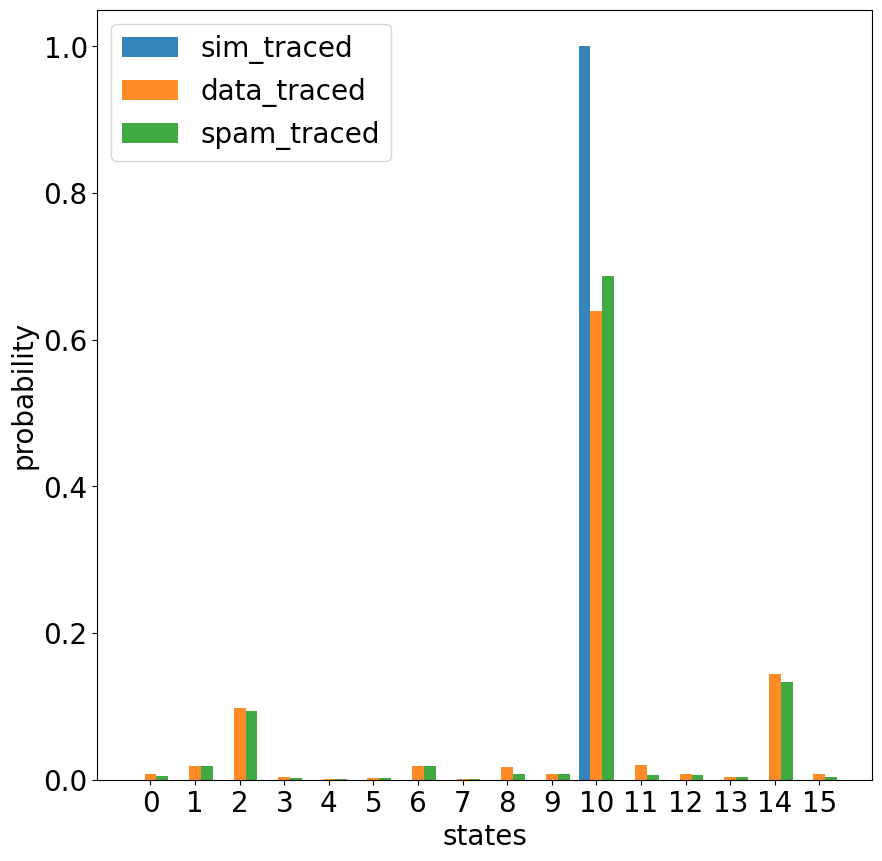

2023-05-16-231344_Line_015.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:RX+31:FTXA130.2500+:RY+11:RX+31:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:FTXA130.2500+:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



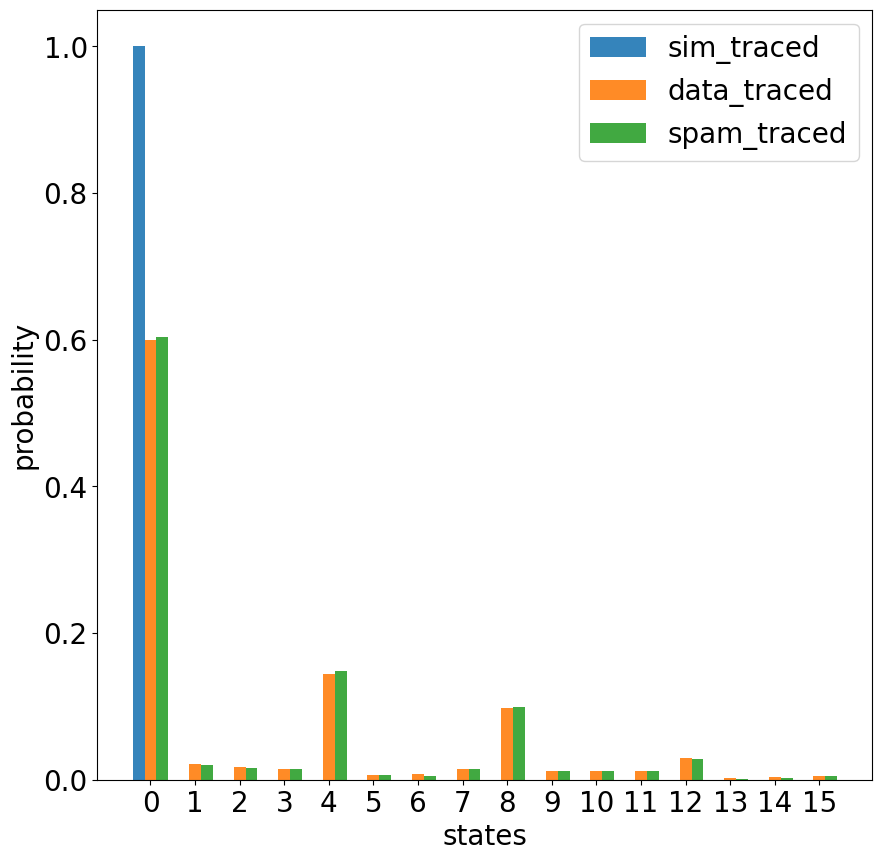

2023-05-16-231435_Line_016.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:RY+31:FTXA130.2500+:AZ1+1.0000:RY+31:FTXA130.2500+:RX+11:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



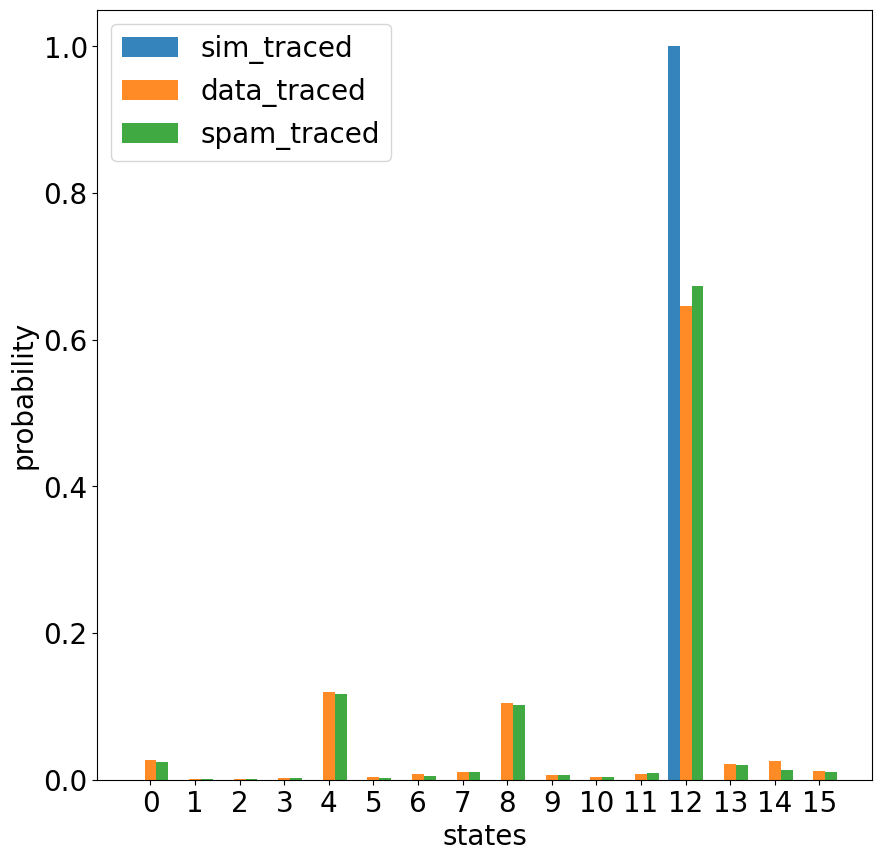

2023-05-16-231643_Line_017.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:RX+31:FTXA130.2500+:RY+11:RY+31:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:RY+11:AZ3+1.0000:FTXA130.2500+:RX+11:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



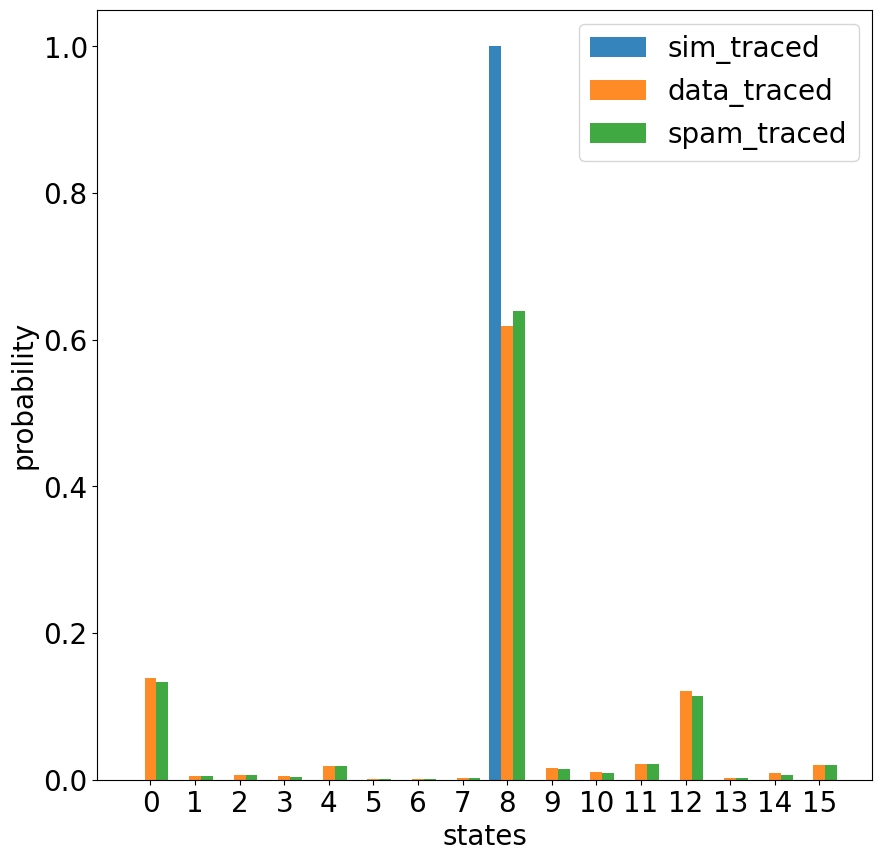

2023-05-16-231733_Line_018.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:RY+31:FTXA130.2500+:FTXA130.2500+:RY+31:FTXA130.2500+:FTXA130.2500+:RY+11:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



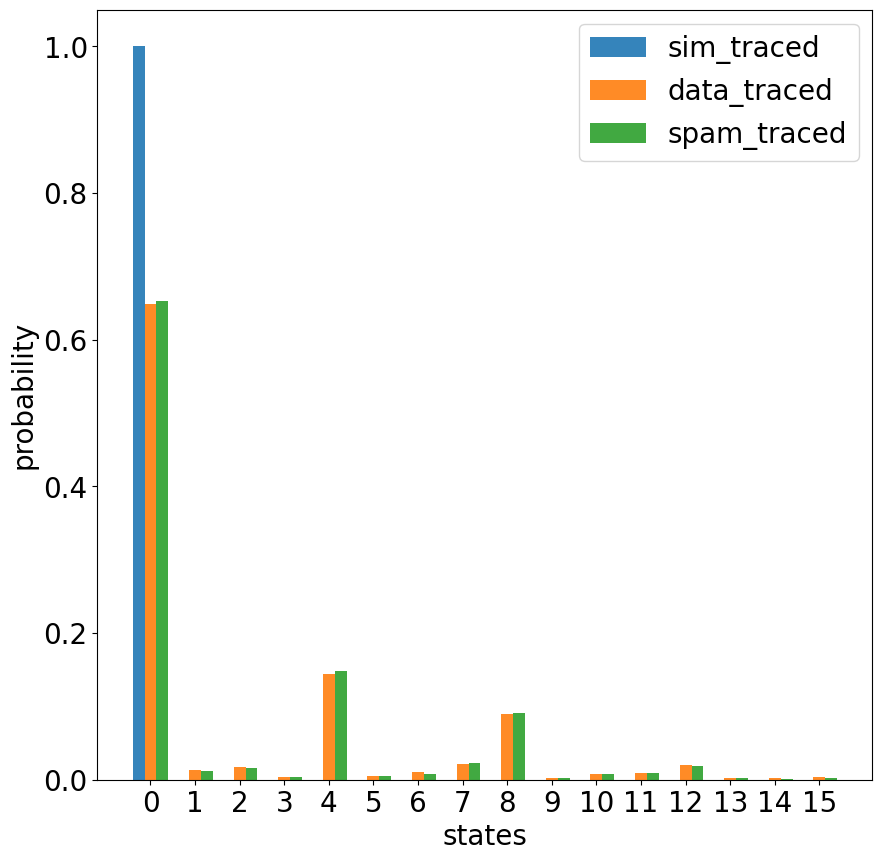

2023-05-16-231823_Line_019.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:RY+31:FTXA130.2500+:AZ1+1.0000:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:FTXA130.2500+:AZ1+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



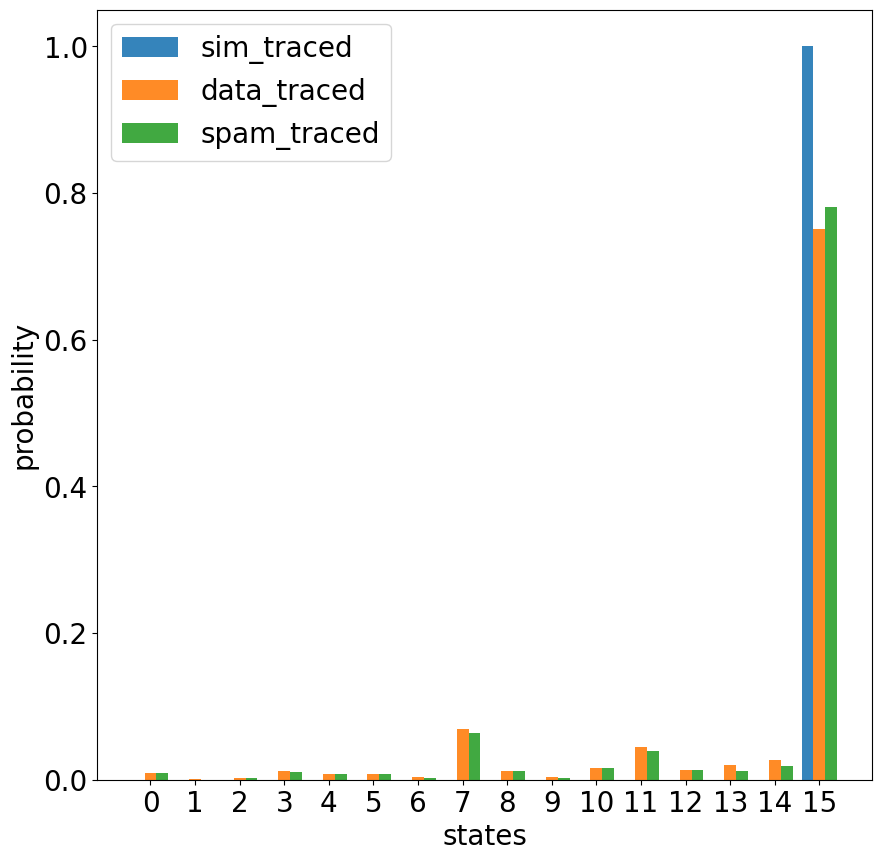

2023-05-16-231914_Line_020.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+31:FTXA130.2500+:RY+31:FTXA130.2500+:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:RX+11:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



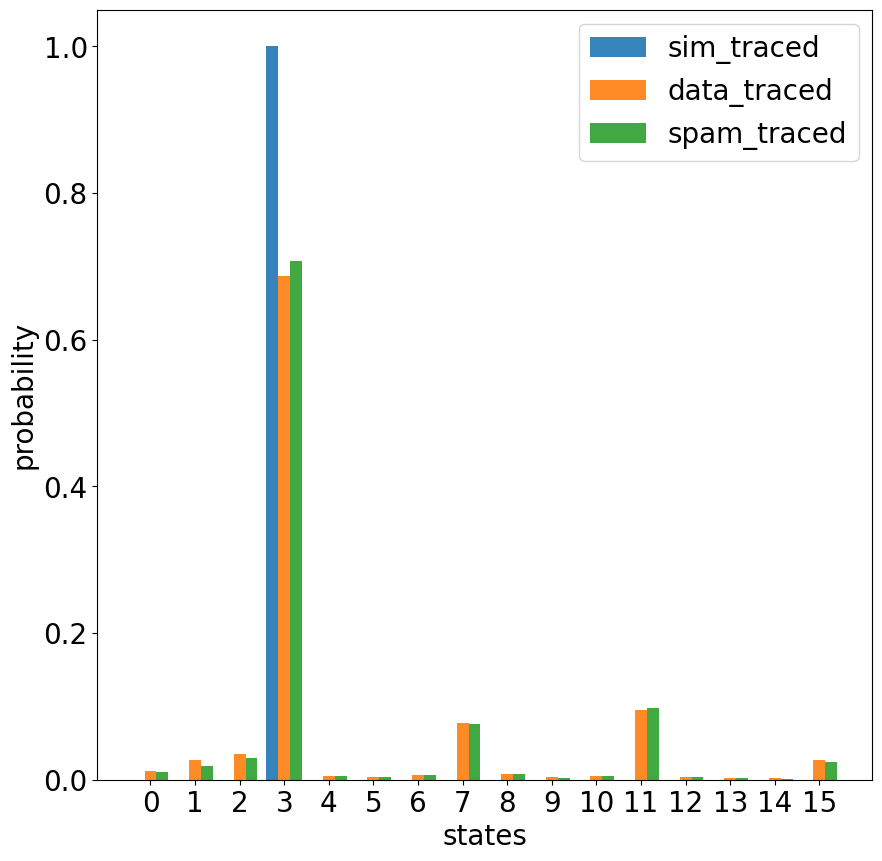

In [16]:
filenames_data=[]
counts_d4=[]
counts_d4_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d4.copy()
print (filenames_data)
# print (len(filenames_data))
paf_data=paf_data_d4
circuit=c_d4
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d4.append(counts_ibm_mapping_dic)
    
    
    a_s=spam1.Correct_SPAM(a)
    data_traced_spam=Trace_Out(a_s,[0,1,2,3])
    counts_spam=[round(shots*x) for x in  data_traced_spam.population]
    counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
    counts_d4_spam.append(counts_ibm_mapping_dic_spam)

    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=4","spam"])
    Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])
# #         

2023-05-16-213002_Line_001.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+11:RY+31:FTXA130.2500+:AZ1+1.0000:AZ3+1.0000:FTXA130.2500+:RY+11:FTXA130.2500+:RX+11:FTXA130.2500+:AZ1+1.0000:RY+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RX+31:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:AZ1+1.0000:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



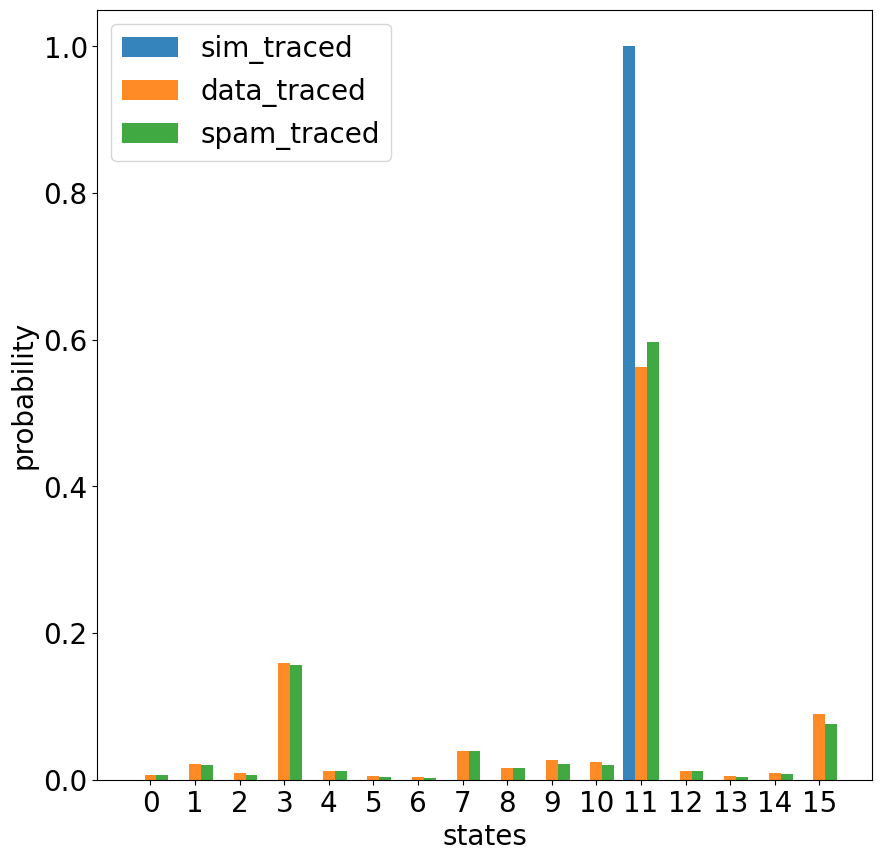

2023-05-16-224044_Line_002.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:RX+31:FTXA130.2500+:RY+11:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:FTXA130.2500+:RY+11:RX+31:FTXA130.2500+:AZ1+1.0000:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:RY+11:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



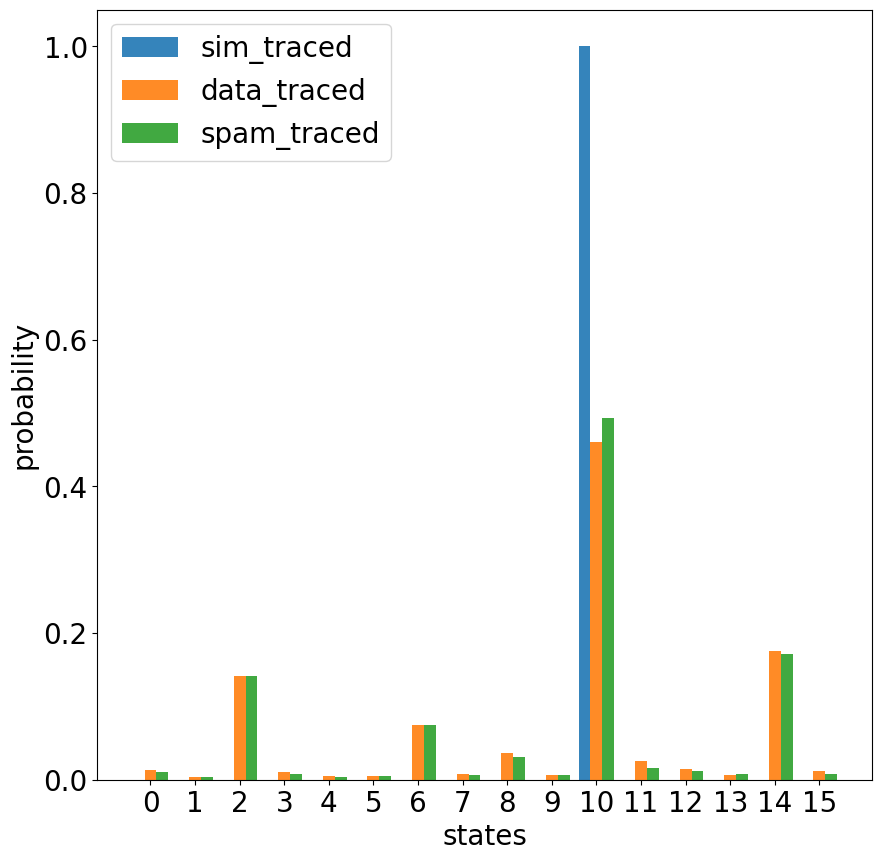

2023-05-16-224152_Line_003.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:RY+31:FTXA130.2500+:AZ1+1.0000:FTXA130.2500+:RX+31:FTXA130.2500+:RY+11:RY+31:FTXA130.2500+:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:AZ1+1.0000:AZ3+1.0000:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:RY+11:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



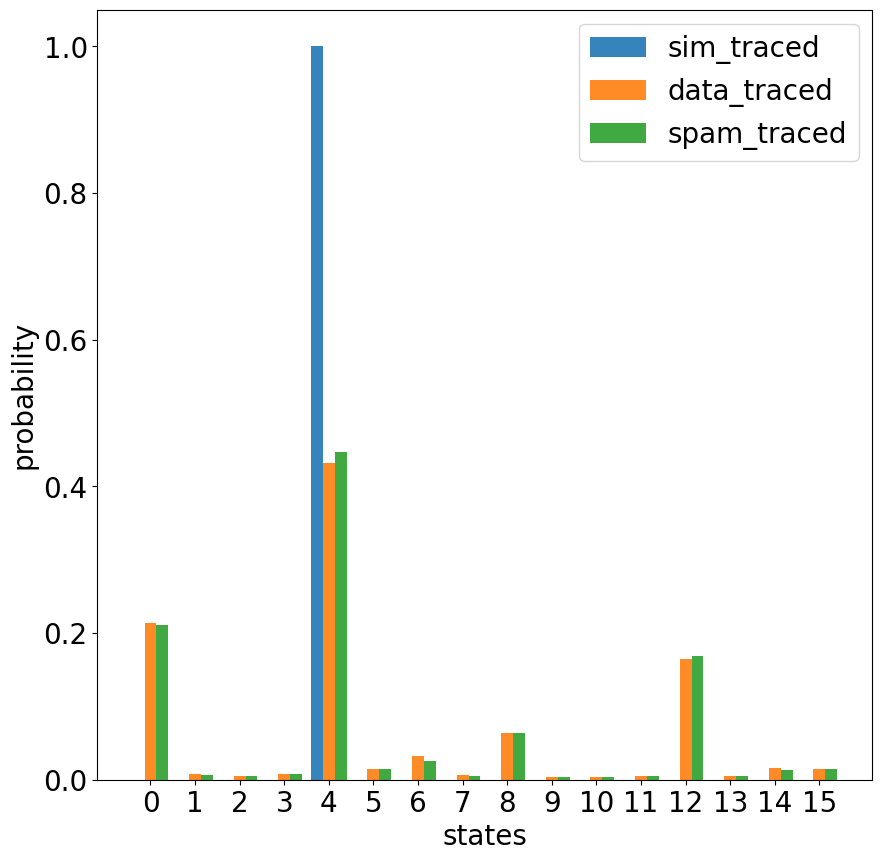

2023-05-16-224300_Line_004.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ3+1.0000:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:AZ1+1.0000:FTXA130.2500+:RY+11:RY+31:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:RY+11:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



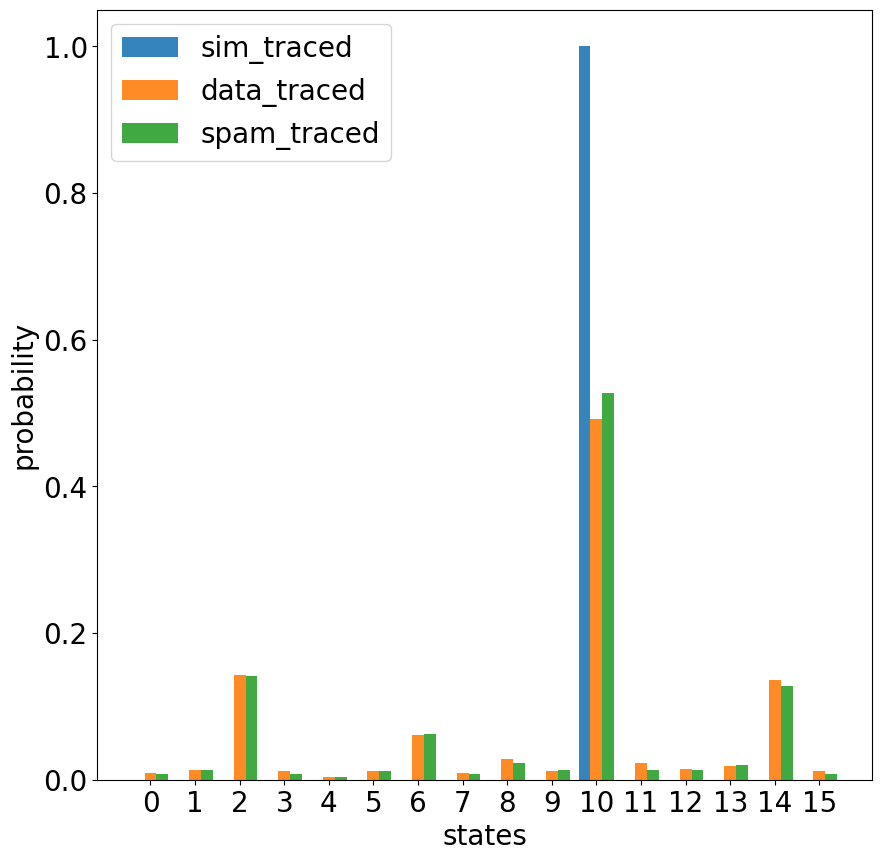

2023-05-16-220342_Line_005.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:FTXA130.2500+:AZ1+1.0000:AZ3+1.0000:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:AZ1+1.0000:AZ3+1.0000:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:RY+31:FTXA130.2500+:RX+11:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



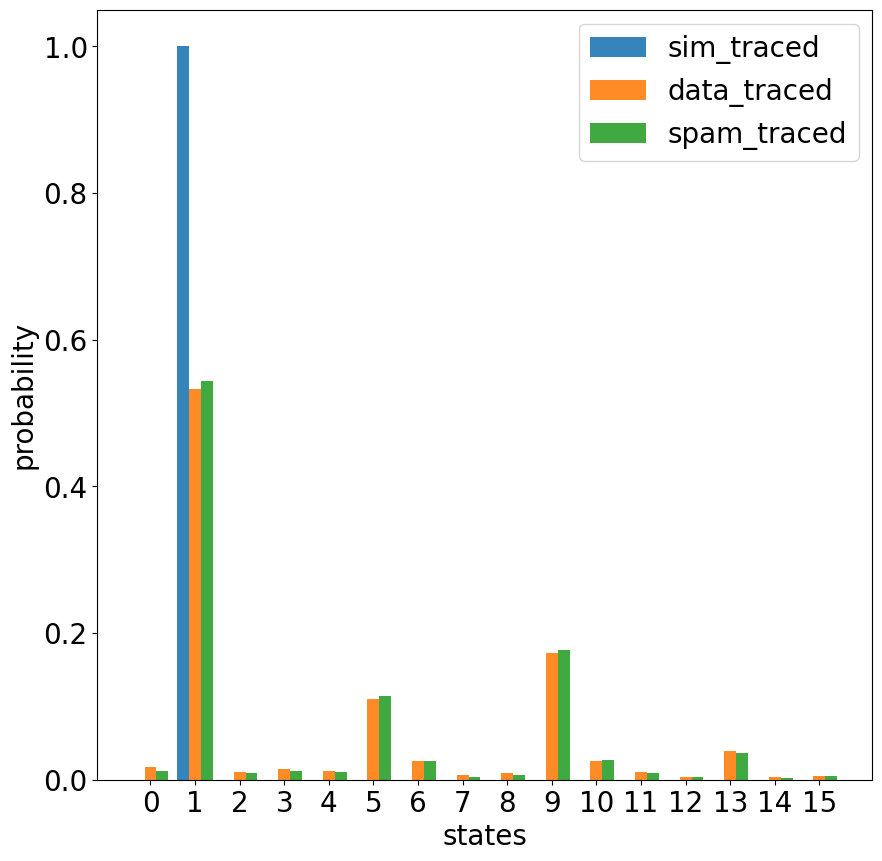

2023-05-16-220606_Line_006.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:RY+31:FTXA130.2500+:RY+11:AZ3+1.0000:FTXA130.2500+:RY+31:FTXA130.2500+:RY+11:RX+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RY+31:FTXA130.2500+:RX+11:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



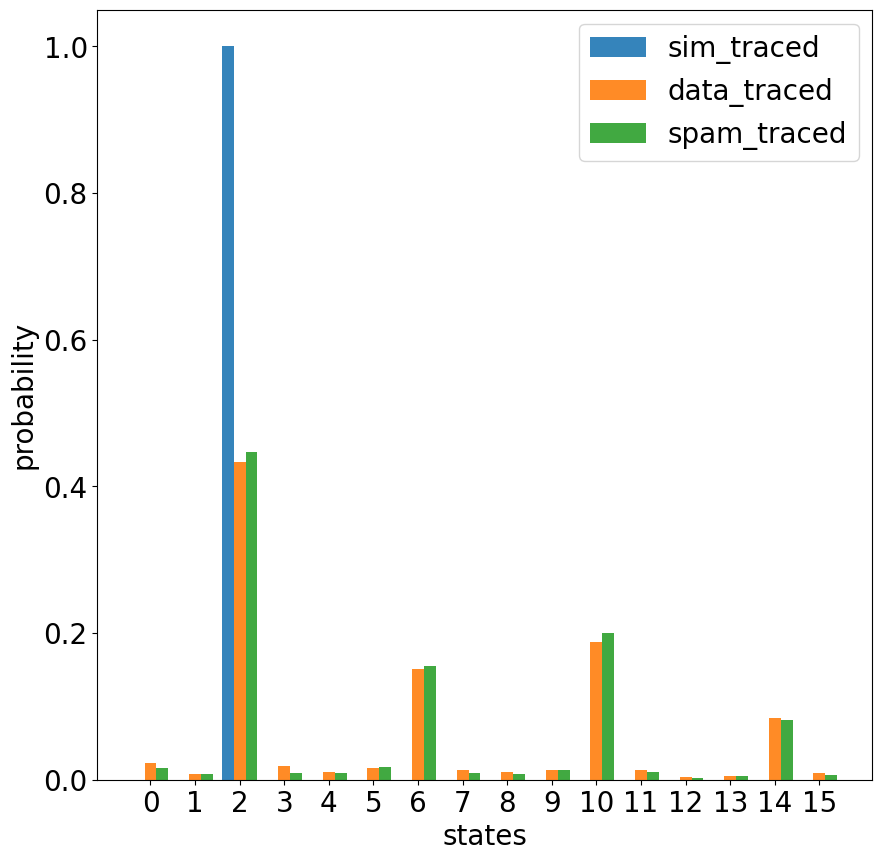

2023-05-16-220712_Line_007.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:RX+31:FTXA130.2500+:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:RY+31:FTXA130.2500+:FTXA130.2500+:RX+11:FTXA130.2500+:RX+11:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



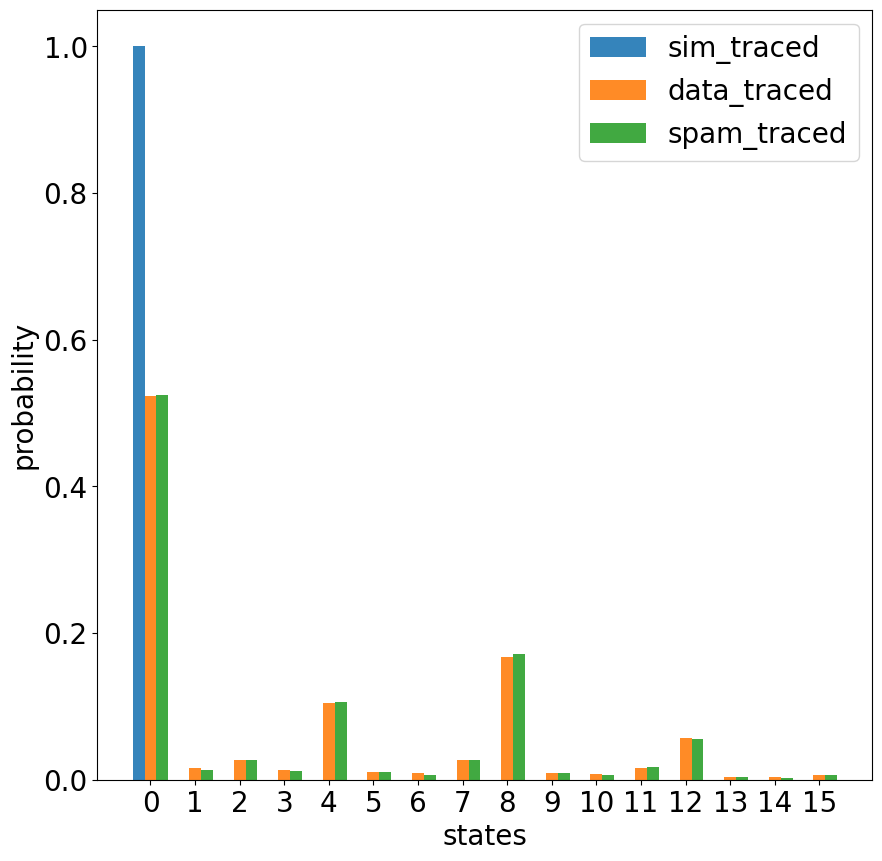

2023-05-16-220820_Line_008.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+31:FTXA130.2500+:AZ1+1.0000:RY+31:FTXA130.2500+:RX+11:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RY+11:AZ3+1.0000:FTXA130.2500+:RY+31:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:AZ1+1.0000:FTXA130.2500+:AZ1+1.0000:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



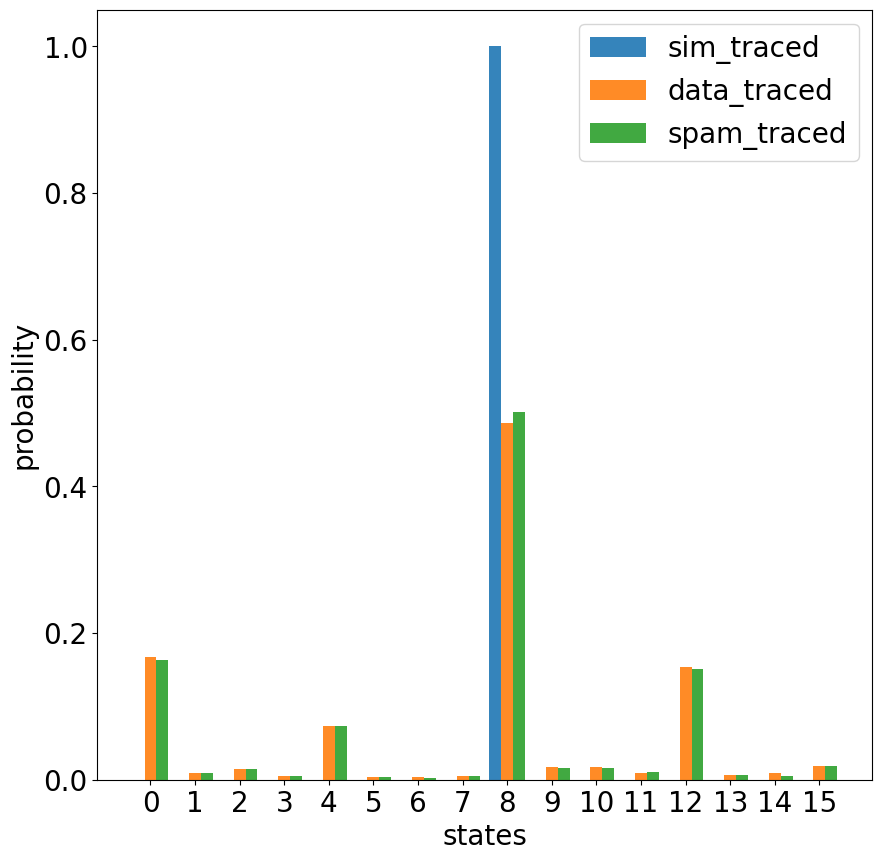

2023-05-16-221044_Line_009.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:AZ3+1.0000:FTXA130.2500+:RX+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RX+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RY+11:RX+31:FTXA130.2500+:RY+11:RY+31:FTXA130.2500+:RY+11:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



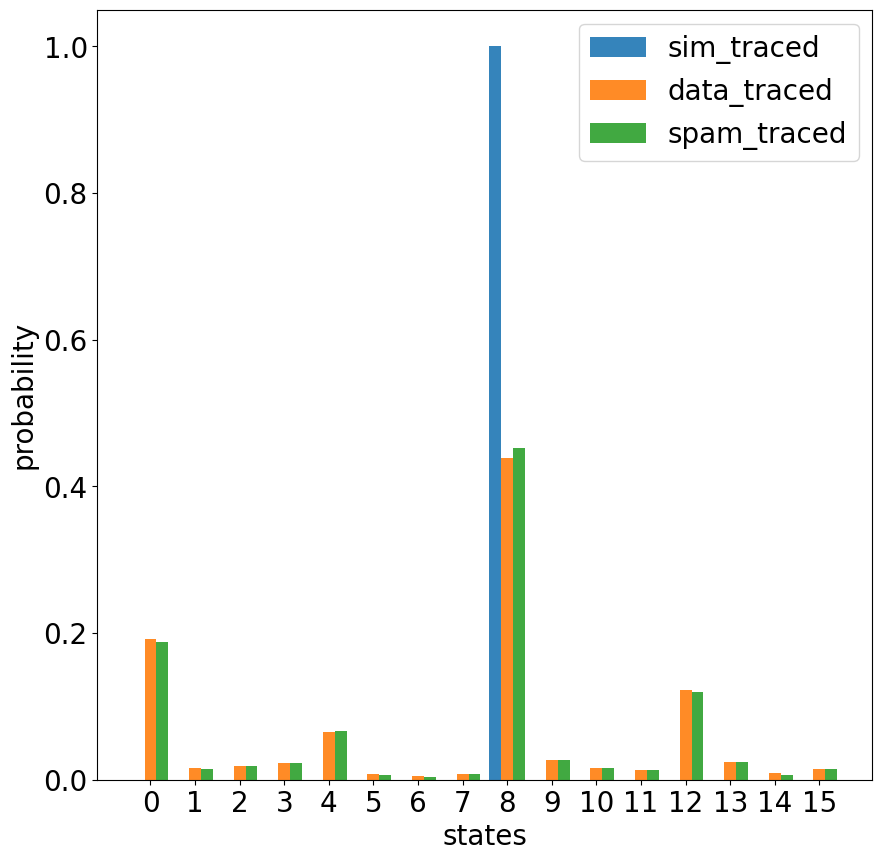

2023-05-16-221152_Line_010.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:FTXA130.2500+:RY+11:AZ3+1.0000:FTXA130.2500+:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:RX+31:FTXA130.2500+:RY+11:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:RX+11:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



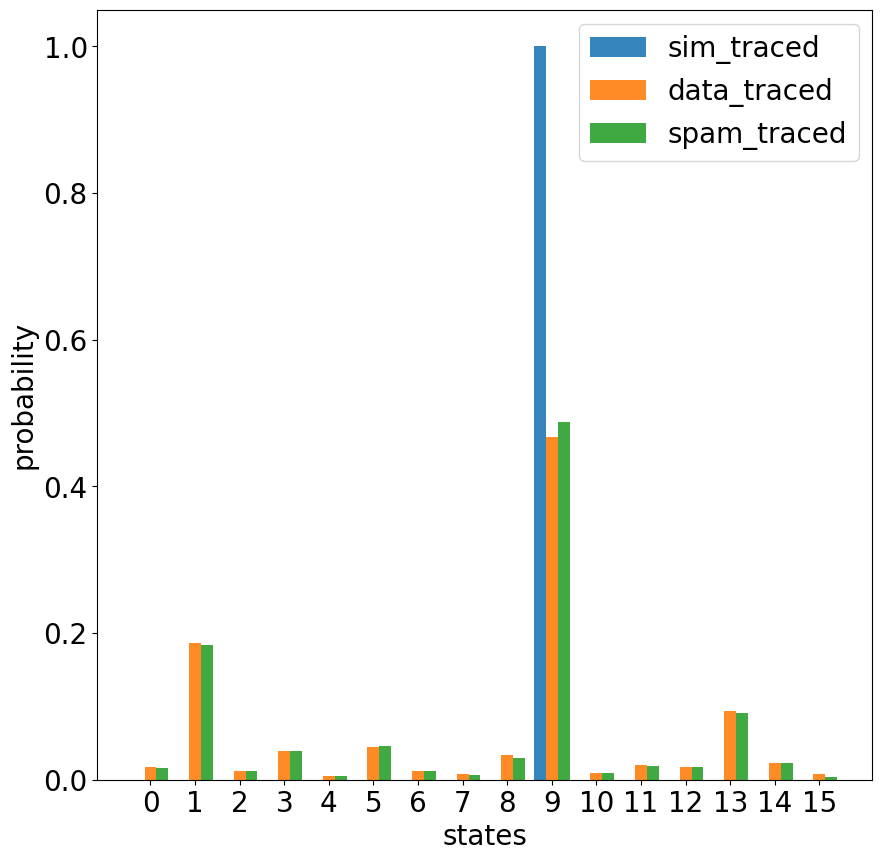

2023-05-16-221259_Line_011.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:RY+31:FTXA130.2500+:RY+11:RY+31:FTXA130.2500+:RY+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:FTXA130.2500+:RX+11:FTXA130.2500+:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



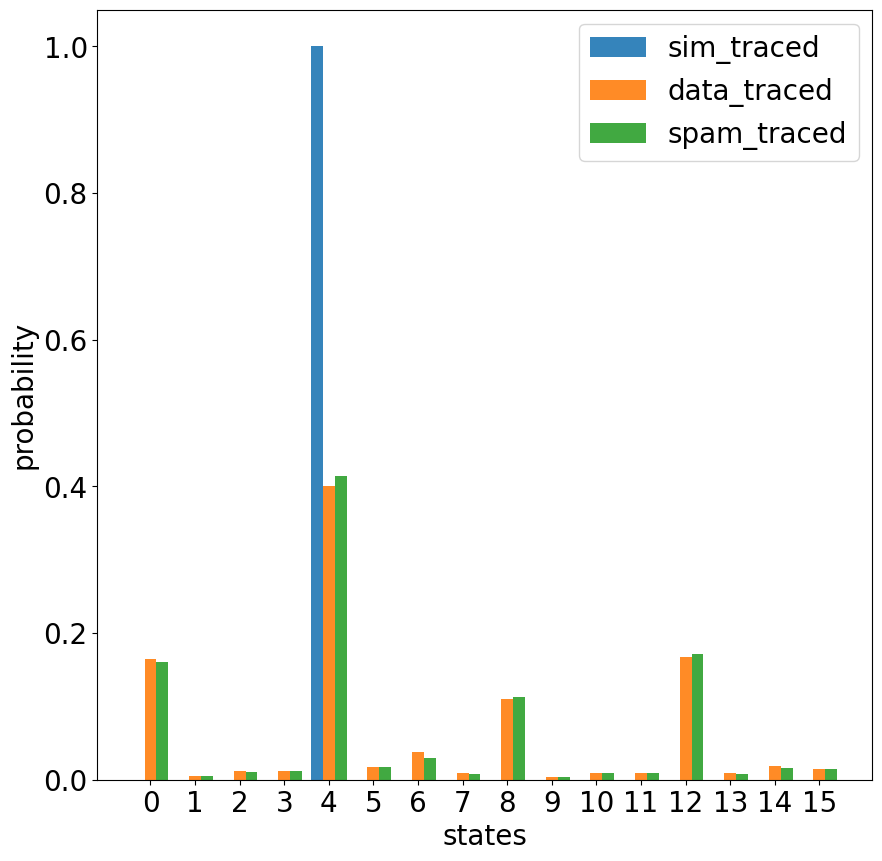

2023-05-16-221523_Line_012.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ3+1.0000:FTXA130.2500+:RX+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RX+31:FTXA130.2500+:RY+11:RY+31:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:AZ3+1.0000:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:RY+11:AZ3+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



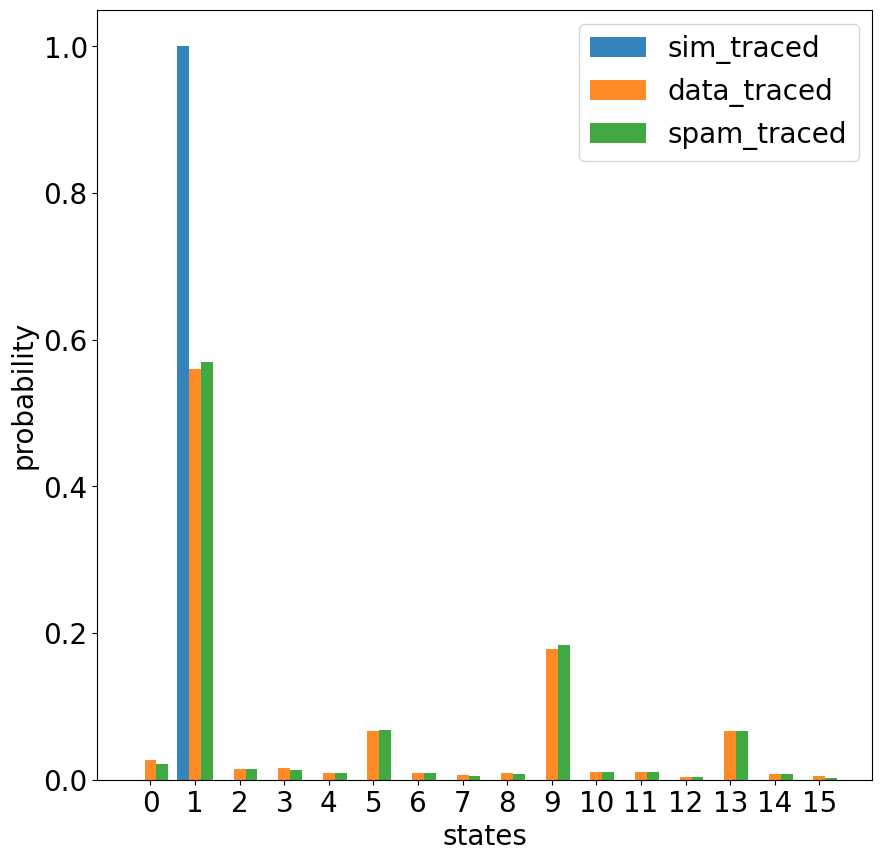

2023-05-16-230908_Line_013.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ3+1.0000:FTXA130.2500+:RX+31:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:RY+11:RX+31:FTXA130.2500+:RY+11:RY+31:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:RX+31:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:RY+11:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



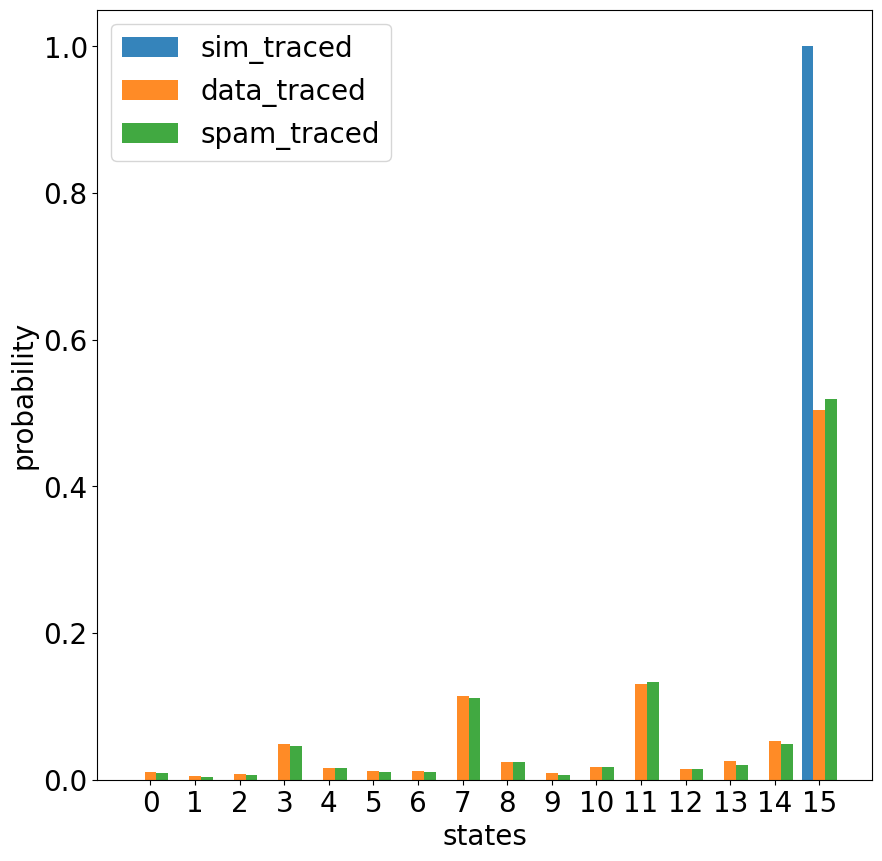

2023-05-16-224711_Line_014.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:RX+31:FTXA130.2500+:RY+11:FTXA130.2500+:RX+31:FTXA130.2500+:RY+11:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:FTXA130.2500+:RY+11:RX+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RY+11:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



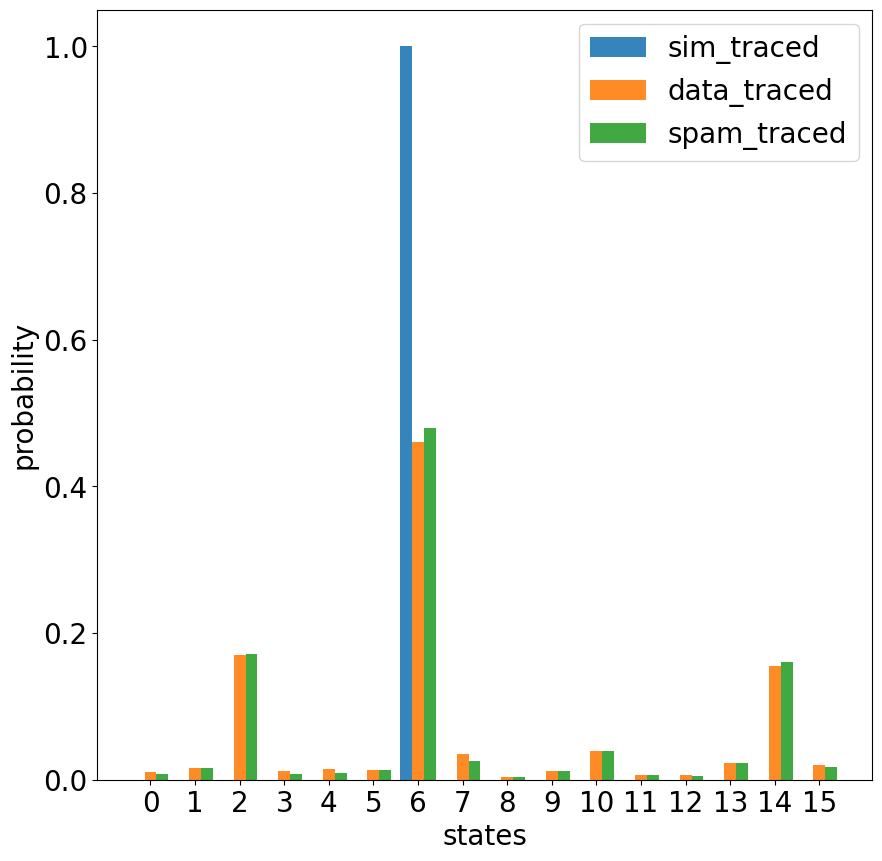

2023-05-16-224818_Line_015.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:RX+31:FTXA130.2500+:RY+11:FTXA130.2500+:RX+31:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:RX+11:FTXA130.2500+:AZ1+1.0000:RY+31:FTXA130.2500+:FTXA130.2500+:FTXA130.2500+:RX+11:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



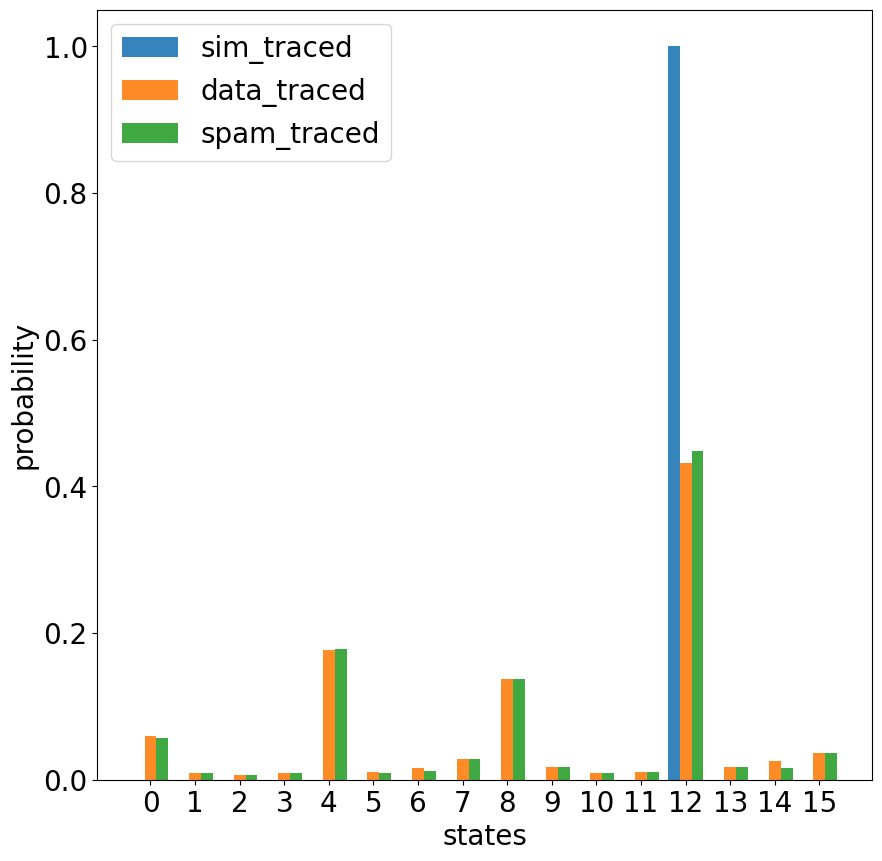

2023-05-16-224926_Line_016.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+11:RY+31:FTXA130.2500+:RY+31:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:RY+11:FTXA130.2500+:AZ1+1.0000:RY+31:FTXA130.2500+:RY+11:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:AZ1+1.0000:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



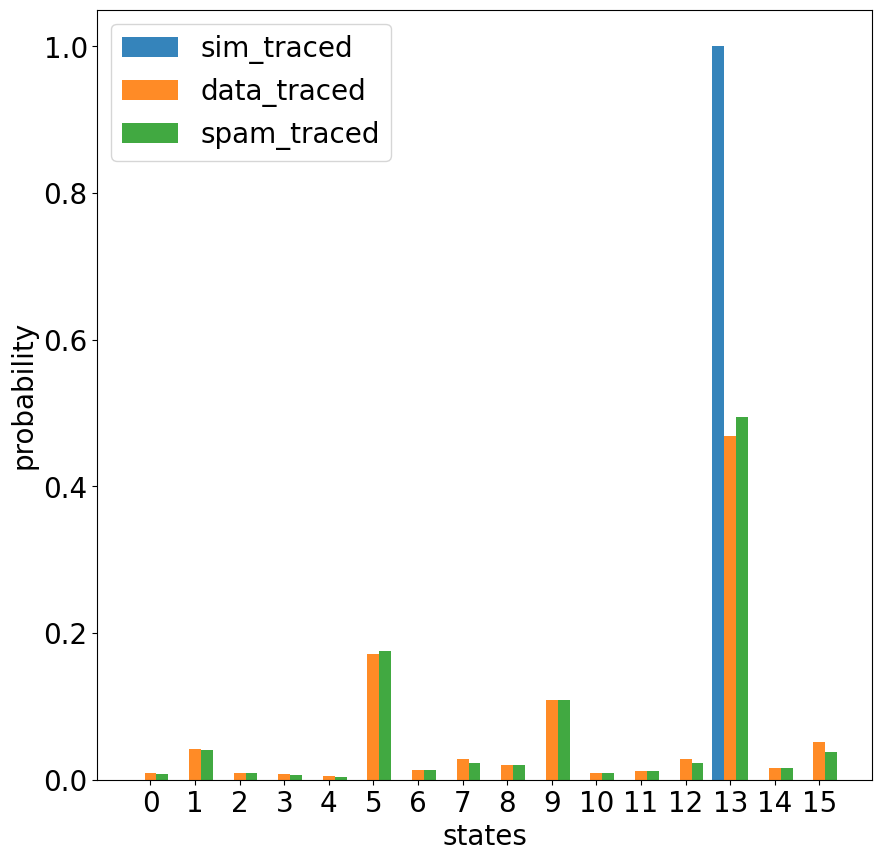

2023-05-16-230148_Line_017.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:FTXA130.2500+:RY+11:RX+31:FTXA130.2500+:RX+11:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RY+11:RY+31:FTXA130.2500+:RY+11:AZ3+1.0000:FTXA130.2500+:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



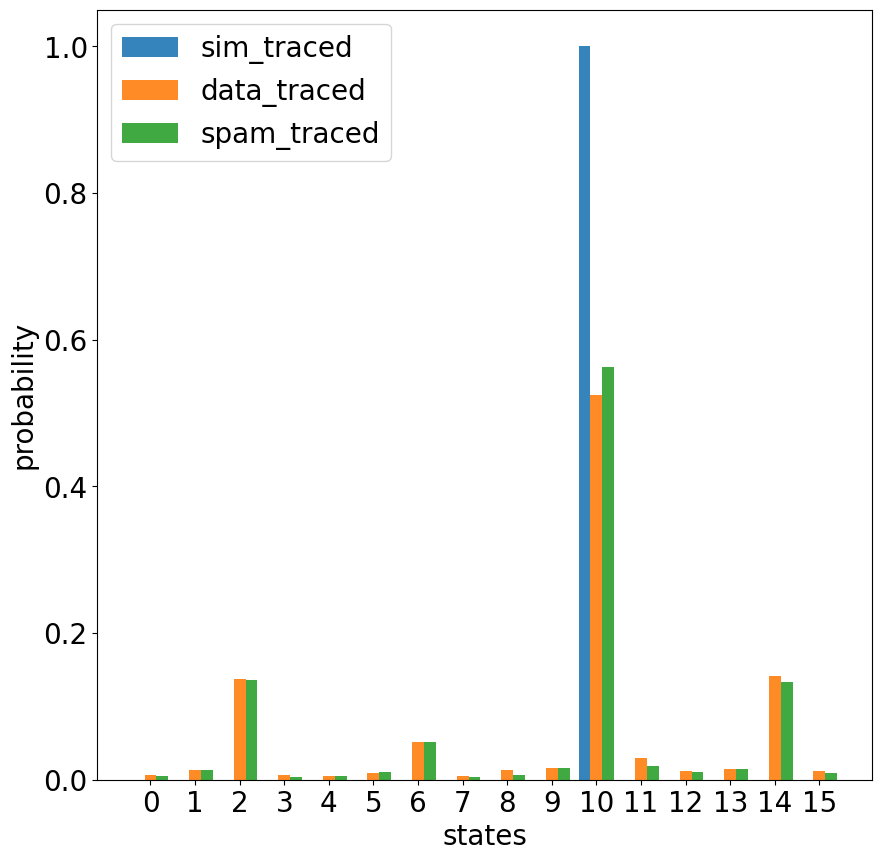

2023-05-16-230256_Line_018.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:AZ3+1.0000:FTXA130.2500+:RY+31:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:RX+31:FTXA130.2500+:RY+11:RX+31:FTXA130.2500+:RY+11:AZ3+1.0000:FTXA130.2500+:RX+31:FTXA130.2500+:RY+11:FTXA130.2500+:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



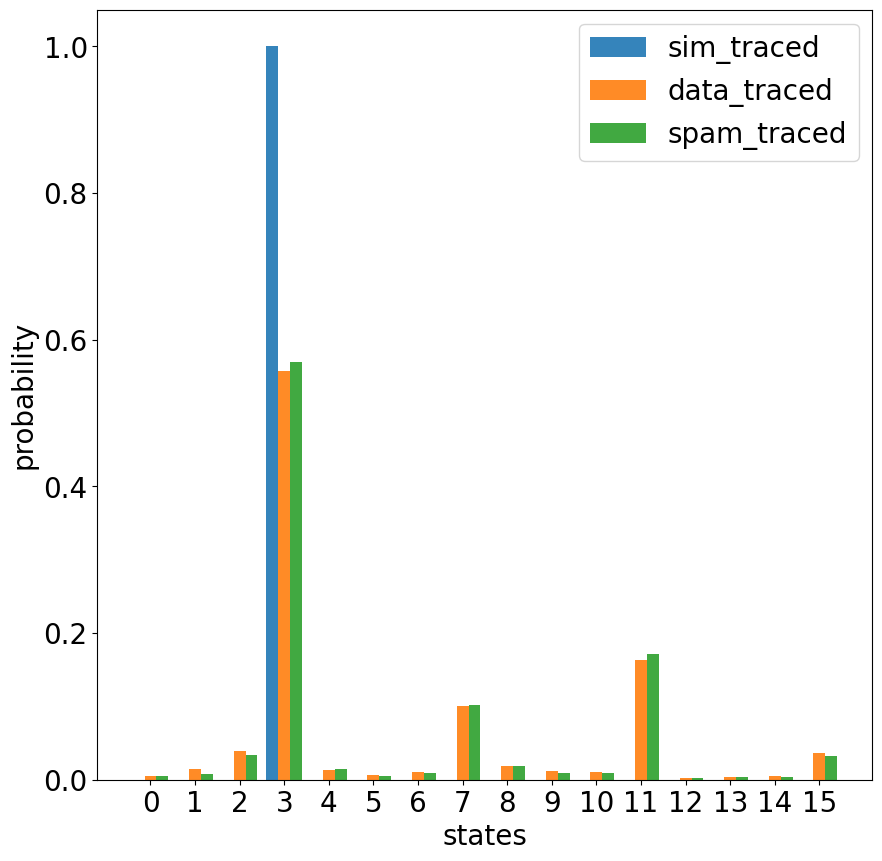

2023-05-16-230519_Line_019.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+11:RY+31:FTXA130.2500+:FTXA130.2500+:AZ1+1.0000:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:RY+11:AZ3+1.0000:FTXA130.2500+:RX+31:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:RY+11:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



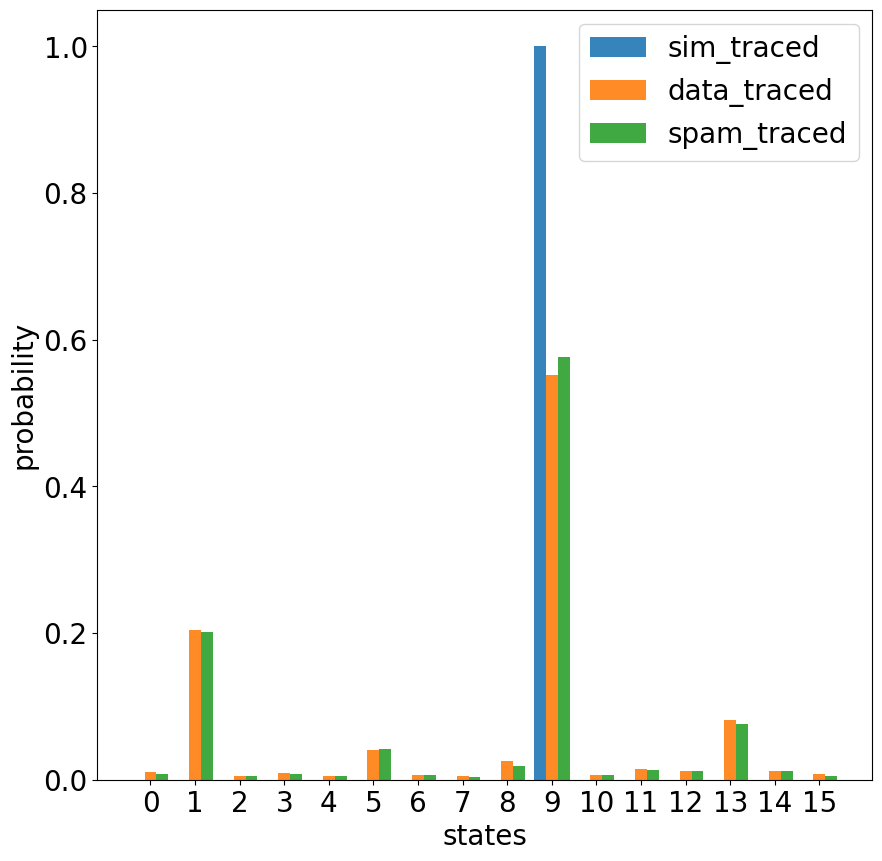

2023-05-16-230629_Line_020.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RY+11:RY+31:FTXA130.2500+:RY+11:RY+31:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:AZ1+1.0000:RX+31:FTXA130.2500+:RX+11:AZ3+1.0000:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:AZ1+1.0000:RY+31:FTXA130.2500+:RX+31:FTXA130.2500+:RX+11:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3



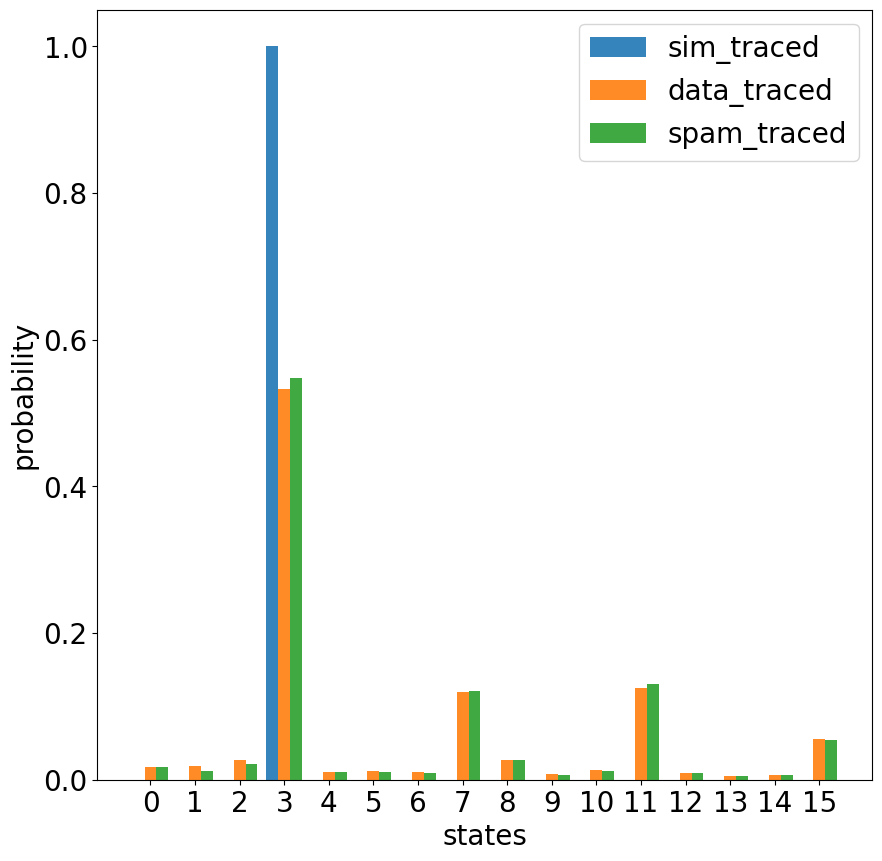

In [17]:
filenames_data=[]
counts_d8=[]
counts_d8_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d8.copy()
# print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d8
circuit=c_d8
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d8.append(counts_ibm_mapping_dic)
    
    a_s=spam1.Correct_SPAM(a)
    data_traced_spam=Trace_Out(a_s,[0,1,2,3])
    counts_spam=[round(shots*x) for x in  data_traced_spam.population]
    counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
    counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])

In [18]:
# print (counts_d2[0])
# print (counts_d2_spam[0])

In [19]:
import copy
from copy import copy, deepcopy

# copy.copy(x)
# copy.deepcopy(x)

# picklefile="c39b72eb-9de9-4338-b6ae-e478130a3f4fXX23541withpadding_set2"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/0516/13452 0516 FT explicit CNOT R rotations auto/9c845ecd-7110-4fa0-bea0-9287796dc4e5XX13452noS_explicitCNOT_FT_Rrotations0516", "rb") as fp:   # Unpickling
    eab_load = pickle.load(fp)
# print (picklefile)
# print (b)

# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424 /"+picklefile, "rb") as fp:   # Unpickling
#     eab_load_2 = pickle.load(fp)
# print (picklefile)

# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424 /"+picklefile, "rb") as fp:   # Unpickling
#     eab_load_3 = pickle.load(fp)
# print (picklefile)


C=20
eab_load_cpy=deepcopy(eab_load[0:60])
eab_load_cpy_spam=deepcopy(eab_load[0:60])
# eab_load_cpy_24=deepcopy(eab_load[0:20]) #a copy that only has depth=[2,4]


In [20]:
for i in range (C):
#     print (i)
    assert eab_load_cpy[i]["L"]==2
    eab_load_cpy[i]["counts"]=counts_d2[i].copy()


    
for i in range (C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==2
    eab_load_cpy_spam[i]["counts"]=counts_d2_spam[i].copy()



# for i in range (C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])

In [21]:
for i in range (C,2*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==4
    eab_load_cpy[i]["counts"]=counts_d4[i-C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i]["counts"])
    
for i in range (C,2*C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==4
    eab_load_cpy_spam[i]["counts"]=counts_d4_spam[i-C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

# for i in range (C,2*C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])    

In [22]:
for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==8
    eab_load_cpy[i]["counts"]=counts_d8[i-2*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==8
    eab_load_cpy_spam[i]["counts"]=counts_d8_spam[i-2*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

# for i in range (2*C,3*C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])    

In [23]:
# print (eab_load_cpy)
# filename = str(uuid.uuid4())
# filename+="FTXX13_mapping1345_R_0516_00+11_ExperimentalData"
# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0516 FTXX 13452/13452 explicit CNOT FT R/results/"+filename, "wb") as fp:
#     pickle.dump(eab_load_cpy, fp)


In [24]:
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
import EAB_process_modified 
import itertools
import pdb

'''Specify a set of Pauli you want to estimate'''
# C=10
C=20
nqubit=2
depth=[2,4,8]
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full

#process_EAB(Lrange, cb_data, pauli_request_list)
eab_result=EAB_process_modified.process_EAB(depth, eab_load_cpy_spam, pauli_request_list)
# eab_result_spam=EAB_process_modified.process_EAB(depth, eab_load_cpy_spam, pauli_request_list)

print (eab_result)


{'fidelity_list': {'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'IX': {2: [0.837, 0.7459364841210303, 0.7555611097225694, 0.7584396099024756, 0.7695, 0.664, 0.7915, 0.7524381095273819, 0.8175, 0.7970507373156711, 0.746436609152288, 0.7915, 0.6875, 0.8239559889972493, 0.7646176911544228, 0.7061469265367316, 0.8270432391902024, 0.7262947210407806, 0.7555611097225694, 0.7986006996501749], 4: [0.7739434858714679, 0.689344672336168, 0.689, 0.6745813546613346, 0.679, 0.7583791895947974, 0.6953476738369184, 0.6690827293176705, 0.6865783554111472, 0.7035741064733817, 0.7105, 0.7305673581604599, 0.7064266066516629, 0.7140714821294676, 0.6545, 0.6754188547136785, 0.6555, 0.7300674831292177, 0.792448112028007, 0.71042760690

In [39]:
from scipy.optimize import curve_fit
def rcs_fit_fun_depth1(x, alpha):
        #return a * np.exp(-alpha * x)
        return alpha ** x

def fit_EAB_depth1(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
        alpha = params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[0]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0


    return alpha, alpha_err

    print(alpha, alpha_err)

In [40]:
# raw_fidelity_list = eab_result["fidelity_list"]

# #######depth=[2]#########
# ##########################
# plot_dic={}
# error_dic={}
# err=[]
# # sys.exit(0)
# depth=[2]
# fidelity_list = {}
# stdev_list = {}

# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         fidelity_list[pauli_label] = 1.0
#         stdev_list[pauli_label] = 0.0
#     else:
#         alpha, alpha_err = fit_EAB_depth1(depth, raw_fidelity_list[pauli_label])
#         fidelity_list[pauli_label] = alpha
#         stdev_list[pauli_label] = alpha_err

# # print(fidelity_list)

# # print(stdev_list)

# print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
# use_density_matrix=False
# use_readout_error =False
# shots=4000
# if use_density_matrix:
#     print("Density matrix based simulation")
# else:
#     print("Measurement based simulation, shots = %d" % shots)

# if use_readout_error is True:
#     print("Measurement bitflip rate = %f" % eps_readout)
# else:
#     print("No readout error")

# # Average fidelity
# print("Total error = ", 1-np.mean(list(fidelity_list.values())))

# print("Label / Pauli infidelity / Standard deviation")
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
#     plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
#     error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

# plot_2={}
# plot_2=deepcopy(plot_dic)
# err_2=deepcopy(error_dic)

# #######depth=[2]#########
# ##########################
# plot_dic={}
# err=[]
# # sys.exit(0)
# depth=[2,4]
# fidelity_list = {}
# stdev_list = {}

# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         fidelity_list[pauli_label] = 1.0
#         stdev_list[pauli_label] = 0.0
#     else:
#         alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
#         fidelity_list[pauli_label] = alpha
#         stdev_list[pauli_label] = alpha_err

# # print(fidelity_list)

# # print(stdev_list)

# print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
# use_density_matrix=False
# use_readout_error =False
# shots=4000
# if use_density_matrix:
#     print("Density matrix based simulation")
# else:
#     print("Measurement based simulation, shots = %d" % shots)

# if use_readout_error is True:
#     print("Measurement bitflip rate = %f" % eps_readout)
# else:
#     print("No readout error")

# # Average fidelity
# print("Total error = ", 1-np.mean(list(fidelity_list.values())))

# print("Label / Pauli infidelity / Standard deviation")
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
#     plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
#     error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

# plot_24={}
# plot_24=deepcopy(plot_dic)
# err_24=deepcopy(error_dic)

# #######depth=[2]#########
# ##########################
# plot_dic={}
# error_dic={}
# error_dic={}
# err=[]
# # sys.exit(0)
# depth=[2,4,8]
# fidelity_list = {}
# stdev_list = {}

# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         fidelity_list[pauli_label] = 1.0
#         stdev_list[pauli_label] = 0.0
#     else:
#         alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
#         fidelity_list[pauli_label] = alpha
#         stdev_list[pauli_label] = alpha_err

# # print(fidelity_list)

# # print(stdev_list)

# print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
# use_density_matrix=False
# use_readout_error =False
# shots=4000
# if use_density_matrix:
#     print("Density matrix based simulation")
# else:
#     print("Measurement based simulation, shots = %d" % shots)

# if use_readout_error is True:
#     print("Measurement bitflip rate = %f" % eps_readout)
# else:
#     print("No readout error")

# # Average fidelity
# print("Total error = ", 1-np.mean(list(fidelity_list.values())))

# print("Label / Pauli infidelity / Standard deviation")
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
#     plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
#     error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

# plot_248={}
# plot_248=deepcopy(plot_dic)
# err_248=deepcopy(error_dic)


In [41]:
def rcs_fit_fun(x, a, alpha):
        #return a * np.exp(-alpha * x)
        return a * (alpha ** x)

def fit_EAB_plot(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
        alpha = params[1]
        a=params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[1]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0

    # params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
    # #params, pcov = curve_fit(rcs_fit_fun, X, Y, absolute_sigma=True, p0=[1,1])


    # print(params)

    return alpha,a, alpha_err,Y, Yerr

    print(alpha, alpha_err)




Parameters: n = 2, C = 20,  L =  [2, 4, 8]
Measurement based simulation, shots = 4000
No readout error
Total error =  0.0707675026853678
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.0766527 0.0048889
YI 0.0823781 0.0053268
ZI 0.0185302 0.0018453
IX 0.0672387 0.0067798
XX 0.1234451 0.0091569
YX 0.1110884 0.0087205
ZX 0.0698884 0.0076421
IY 0.0701012 0.007461
XY 0.11667 0.008234
YY 0.1211933 0.0092006
ZY 0.0718296 0.0074968
IZ 0.0224242 0.00219
XZ 0.0864997 0.0052374
YZ 0.0826181 0.0051542
ZZ 0.0117224 0.002029
{'IX': [0.7658291518016773, 0.7049379535608553, 0.44539448956126987], 'IY': [0.7287804484734356, 0.6642322190300941, 0.41842458620644585], 'IZ': [0.9054033791562718, 0.8638434962337278, 0.8120019783296069], 'XI': [0.8140829280181485, 0.7469946066621691, 0.5297084286190569], 'XX': [0.6355105103074588, 0.5439876420683725, 0.2731182752300333], 'XY': [0.6177106340792053, 0.5437321355506601, 0.28889292470592676], 'XZ': [0.7569346110808233, 0.6894904837220774, 0.4811415

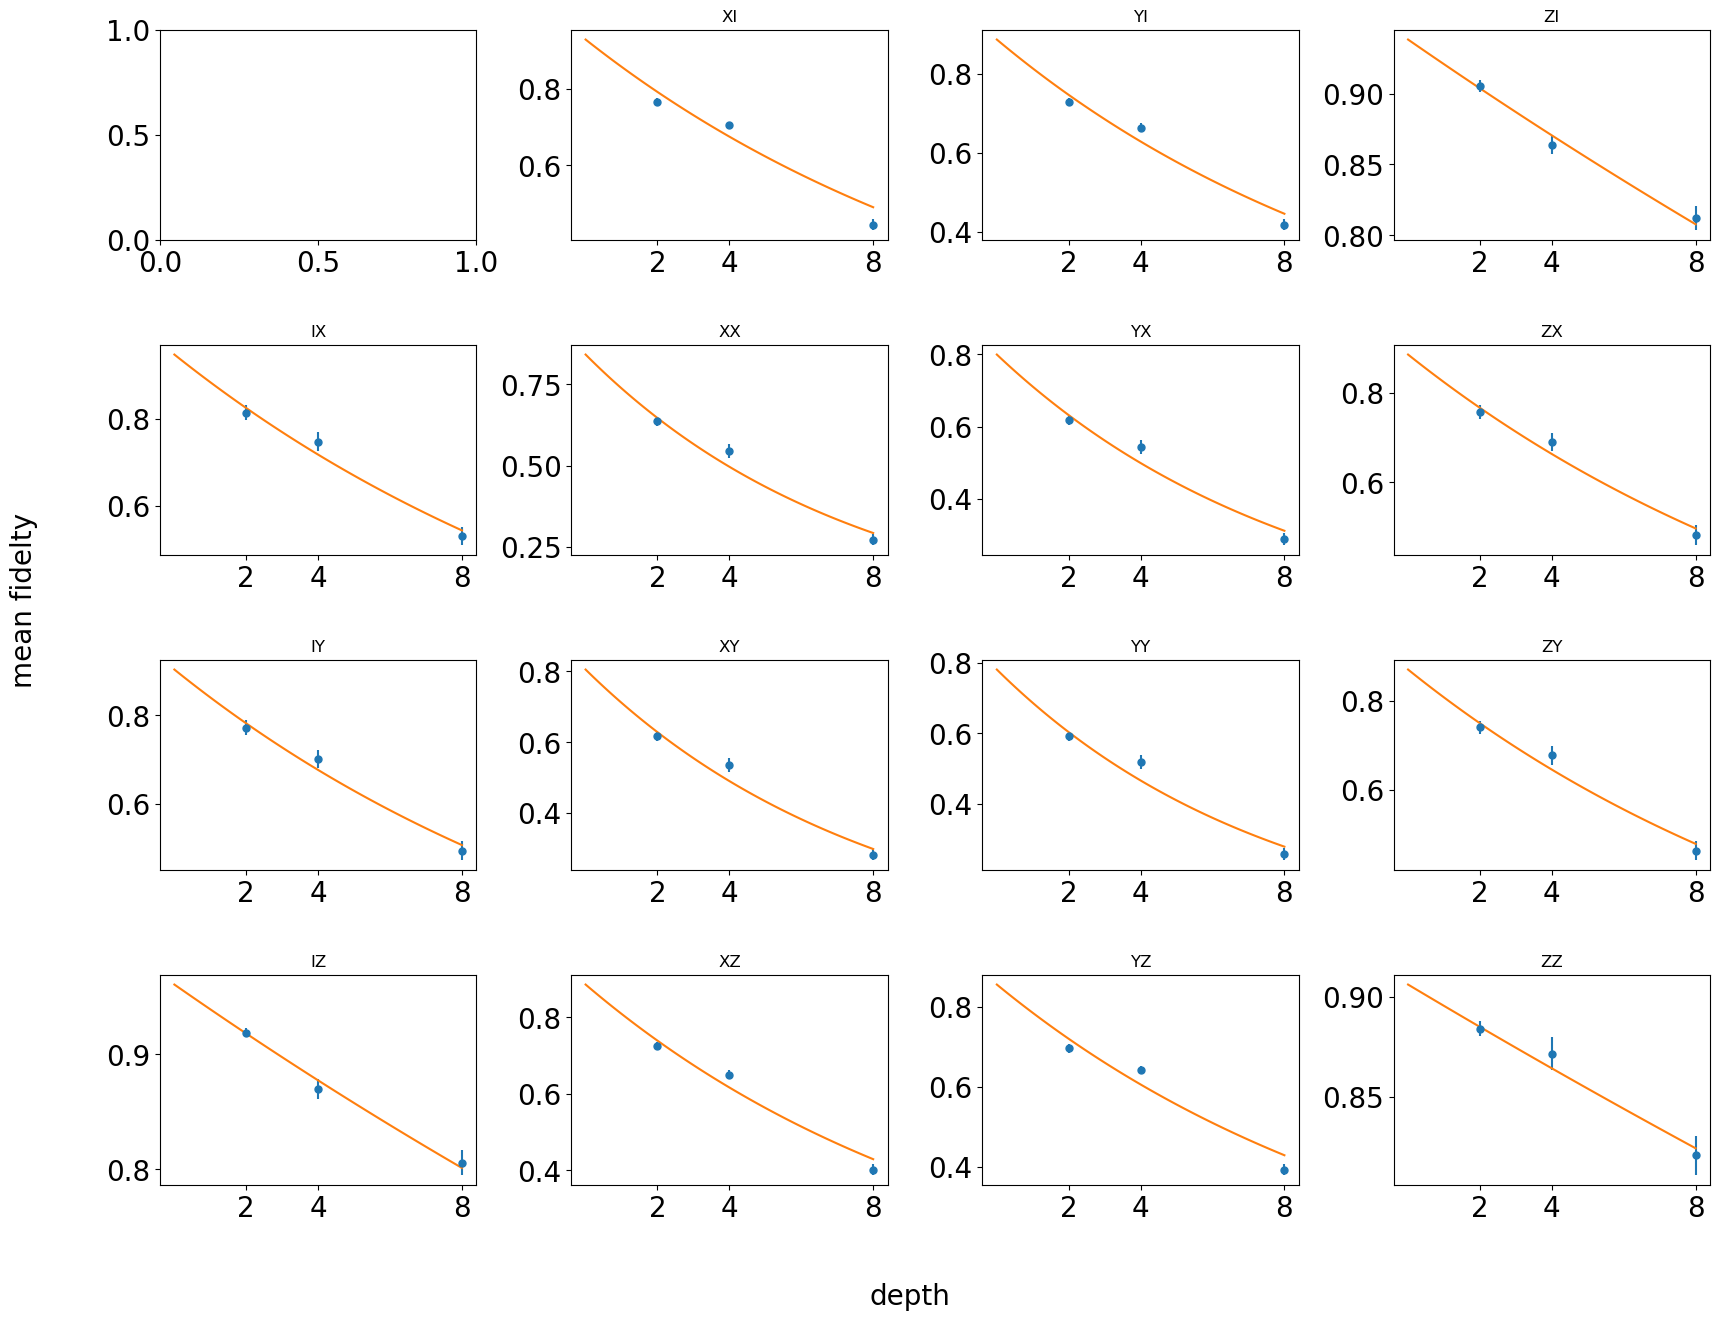

In [42]:
raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
depth=[2,4,8]
fidelity_list = {}
stdev_list = {}
a248_dic={}
Y248_dic={}
Yerr248_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a248_dic[pauli_label]=a 
        Y248_dic[pauli_label]=Y
        Yerr248_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=4000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(1-fidelity_list[pauli_label],7), round(stdev_list[pauli_label],7))
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=round(1-fidelity_list[pauli_label],7)
    error_dic[pauli_label[::-1]]=round (stdev_list[pauli_label],7)
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], fidelity_list[pauli_label])

plot_248={}
plot_248=deepcopy(plot_dic)
err_248=deepcopy(error_dic)
print (Y248_dic)

x_c=np.linspace(0,8,num=80)
nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks([2,4,8])   
            axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        

In [43]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(error_list[pauli_label],7))


Label / Pauli error rates
II 0.9292325
XI 0.0003886
YI 0.0011372
ZI 0.0293007
IX 0.0021148
XX 0.00143
YX 0.0023392
ZX 0.0004377
IY 0.0010981
XY 0.0034248
YY 0.000114
ZY 0.0002535
IZ 0.0231643
XZ 0.0008205
YZ -0.0003892
ZZ 0.0051333


spam results